In [1]:
#optimal transport library
import ot

from sklearn.decomposition import PCA

#bread and butter
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

#machine learning library
import sklearn

#statistics
import scipy

#machine learning library for time series
import numba
from numba import jit, njit

import tqdm
from tqdm import tqdm
import copy
import cvxpy as cp

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
#import numpy as tnp
import warnings
warnings.filterwarnings('ignore')

import dfply
from dfply import *
import math
import seaborn as sns
from scipy import stats
import sklearn
from sklearn import covariance
import itertools
import copy
import math


import matplotlib.pyplot as plt
import torch
import datetime
from datetime import date
from eod import EodHistoricalData

import os
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
import tensorflow.experimental.numpy as tnp
tnp.experimental_enable_numpy_behavior()

#import helpers
import ray
import pytz
import time
#misc
%matplotlib inline
plt.style.use('matplotlibrc')


/Users/hetankevin/miniforge3/lib/python3.9/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
retChar = pd.read_csv('data/RetChar.csv')

In [175]:
#fundamentals = pd.read_stata('data/csrpQuarterly.dta')

In [6]:
#print([col for col in fundamentals.columns])

In [7]:
#csrp.columns

In [4]:
retChar.columns

Index(['Date', 'ret', 'A2ME', 'AC', 'AT', 'ATO', 'BEME', 'Beta', 'C', 'CF',
       'CF2P', 'CTO', 'D2A', 'D2P', 'DPI2A', 'E2P', 'FC2Y', 'IdioVol',
       'Investment', 'Lev', 'LME', 'LT_Rev', 'LTurnover', 'MktBeta', 'NI',
       'NOA', 'OA', 'OL', 'OP', 'PCM', 'PM', 'PROF', 'Q', 'r2_1', 'r12_2',
       'r12_7', 'r36_13', 'Rel2High', 'Resid_Var', 'RNA', 'ROA', 'ROE', 'S2P',
       'SGA2S', 'Spread', 'ST_REV', 'SUV', 'Variance'],
      dtype='object')

In [3]:
csrp = pd.read_stata('data/csrpMonthly.dta')
csrp.index = csrp.datadate
csrp.trt1m /= 100
stockRets = csrp[['tic', 'trt1m']]
stockRets = stockRets.drop_duplicates()
def to_integer(dt_time):
    return 10000*dt_time.year + 100*dt_time.month + dt_time.day
dateArr = np.array(list(map(to_integer, stockRets.index)))
stockRets['date'] = dateArr
stockRets.columns = ['tic', 'ret', 'Date']
stockRets['DR'] = stockRets['Date'] + stockRets['ret']
stockRets = stockRets.dropna()
#mergedRets = retCharDR[['DR']].merge(stockRets, on=['DR'])
#mergedRets

(array([1.30000e+01, 5.00000e+00, 1.00000e+01, 0.00000e+00, 7.00000e+00,
        2.00000e+00, 1.00000e+01, 5.00000e+00, 1.30000e+01, 1.40000e+01,
        1.20000e+01, 7.00000e+00, 2.40000e+01, 5.00000e+00, 2.70000e+01,
        1.80000e+01, 2.40000e+01, 2.20000e+01, 2.20000e+01, 2.40000e+01,
        3.30000e+01, 3.90000e+01, 3.30000e+01, 4.30000e+01, 3.90000e+01,
        7.10000e+01, 5.20000e+01, 6.00000e+01, 8.20000e+01, 6.30000e+01,
        1.08000e+02, 1.15000e+02, 1.21000e+02, 2.03000e+02, 1.71000e+02,
        2.86000e+02, 4.46000e+02, 4.10000e+02, 7.45000e+02, 8.38000e+02,
        1.17600e+03, 1.49100e+03, 2.12200e+03, 2.61000e+03, 3.33200e+03,
        4.78800e+03, 6.11900e+03, 8.25600e+03, 1.12000e+04, 1.46480e+04,
        1.95710e+04, 2.56990e+04, 3.26020e+04, 4.13390e+04, 5.14830e+04,
        6.32610e+04, 7.61120e+04, 8.89150e+04, 1.03805e+05, 1.18079e+05,
        1.31710e+05, 1.44016e+05, 1.54754e+05, 1.63509e+05, 1.69027e+05,
        1.72493e+05, 1.72768e+05, 1.72582e+05, 1.70

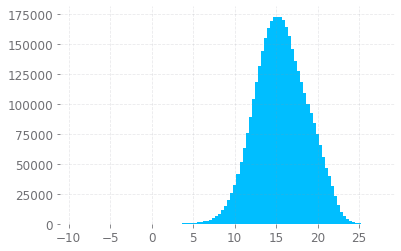

In [4]:
dollars = csrp.cshtrm * csrp.prccm
dollars > dollars.median()
plt.hist(np.log(dollars), bins=100)

In [9]:
#retChar['DR'] = retChar['Date'] + retChar['ret']
#mergedRets = pd.merge_asof(retChar.sort_values('DR'), stockRets.sort_values('DR')[['tic', 'DR']], on='DR', direction='nearest')
#mergedRets = mergedRets.drop('DR', 1)

In [3]:
datesTrain = np.load('data/datasets/char/Char_train.npz')['date']
variablesTrain = np.load('data/datasets/char/Char_train.npz')['variable']
trainSet = np.load('data/datasets/char/Char_train.npz')['data'].transpose(1, 0, 2)

datesVal = np.load('data/datasets/char/Char_valid.npz')['date']
variablesVal = np.load('data/datasets/char/Char_valid.npz')['variable']
valSet = np.load('data/datasets/char/Char_valid.npz')['data'].transpose(1, 0, 2)

datesTest = np.load('data/datasets/char/Char_test.npz')['date']
variablesTest = np.load('data/datasets/char/Char_test.npz')['variable']
testSet = np.load('data/datasets/char/Char_test.npz')['data'].transpose(1, 0, 2)

In [6]:
trainSet.shape

(3686, 240, 47)

In [7]:
valSet.shape

(3347, 60, 47)

In [8]:
testSet.shape

(7141, 300, 47)

In [4]:
trainDF = pd.DataFrame(trainSet.reshape(trainSet.shape[0]*trainSet.shape[1],
                                        trainSet.shape[2]), 
                       index = pd.MultiIndex.from_product([[i for i in range(trainSet.shape[0])],
                                                        datesTrain]),
                       columns = variablesTrain)

valDF = pd.DataFrame(valSet.reshape(valSet.shape[0]*valSet.shape[1],
                                        valSet.shape[2]), 
                       index = pd.MultiIndex.from_product([[i for i in range(valSet.shape[0])],
                                                        datesVal]),
                       columns = variablesVal)

testDF = pd.DataFrame(testSet.reshape(testSet.shape[0]*testSet.shape[1],
                                        testSet.shape[2]), 
                       index = pd.MultiIndex.from_product([[i for i in range(testSet.shape[0])],
                                                        datesTest]),
                       columns = variablesTest)
trainDF

ret      A2ME        AC        AT       ATO      BEME  \
0    19670131  0.136223  0.108392  0.243590  0.152681 -0.182984  0.113054   
     19670228 -0.039703  0.108392  0.241259  0.150350 -0.187646  0.117716   
     19670331  0.152727  0.109302  0.241860  0.148837 -0.188372  0.118605   
     19670428  0.048883  0.109195  0.242529  0.150575 -0.182759  0.116092   
     19670531 -0.022112  0.110599  0.241935  0.154378 -0.184332  0.115207   
...                 ...       ...       ...       ...       ...       ...   
3685 19860829 -0.010414  0.048148 -0.060648 -0.053241 -0.105556 -0.153241   
     19860930  0.147547  0.050973 -0.060241 -0.053753 -0.106580 -0.150602   
     19861031  0.127380  0.052974 -0.061338 -0.051580 -0.106413 -0.149628   
     19861128 -0.030806  0.057056 -0.060317 -0.051933 -0.105030 -0.145552   
     19861231  0.013533  0.061676 -0.061205 -0.050377 -0.104520 -0.142185   

                   Beta         C        CF      CF2P  ...  Resid_Var  \
0    19670131  0.185315  0.113054 -0.271562  0.404429  ...  -0.224942   
     19670228  0.178322  0.113054 -0.271562  0.406760  ...  -0.264569   
     19670331  0.167442  0.111628 -0.272093  0.406977  ...  -0.248837   
     19670428  0.145977  0.113793 -0.272414  0.403448  ...   0.067816   
     19670531  0.154378  0.110599 -0.274194  0.405530  ...   0.101382   
...                 ...       ...       ...       ...  ...        ...   
3685 19860829 -0.010648 -0.203241 -0.193519 -0.252315  ...   0.048148   
     19860930 -0.002317 -0.203429 -0.193698 -0.253475  ...   0.071362   
     19861031 -0.103160 -0.204461 -0.190985 -0.253717  ...   0.168680   
     19861128 -0.105496 -0.207033 -0.191663 -0.252678  ...   0.143223   
     19861231 -0.139360 -0.209981 -0.193974 -0.252825  ...  -0.014124   

                    RNA       ROA       ROE       S2P     SGA2S    Spread  \
0    19670131  0.045455  0.059441  0.080420 -0.015152 -0.383450 -0.164336   
     19670228  0.040793  0.057110  0.078089 -0.015152 -0.383450  0.175991   
     19670331  0.039535  0.055814  0.076744 -0.013953 -0.383721  0.172093   
     19670428  0.042529  0.056322  0.077011 -0.012644 -0.385057  0.070115   
     19670531  0.039171  0.052995  0.073733 -0.011521 -0.382488 -0.211982   
...                 ...       ...       ...       ...       ...       ...   
3685 19860829 -0.245833 -0.250463 -0.250926  0.098611  0.406481 -0.017593   
     19860930 -0.248842 -0.252549 -0.253012  0.099629  0.408248  0.217794   
     19861031 -0.247677 -0.253253 -0.254182  0.102230  0.407063  0.077138   
     19861128 -0.246623 -0.254075 -0.255007  0.106428  0.406381  0.134839   
     19861231 -0.249058 -0.258004 -0.258004  0.110169  0.407250 -0.196798   

                 ST_REV       SUV  Variance  
0    19670131 -0.241259 -0.325175 -0.182984  
     19670228  0.071096 -0.374126 -0.217949  
     19670331 -0.269767  0.179070  0.025581  
     19670428  0.389655  0.428736  0.226437  
     19670531  0.101382 -0.029954  0.080645  
...                 ...       ...       ...  
3685 19860829  0.352315 -0.299074  0.100000  
     19860930 -0.151993  0.465709  0.144115  
     19861031  0.460502  0.280669  0.187732  
     19861128  0.334653  0.087797  0.153004  
     19861231 -0.174670 -0.221281 -0.000942  

[884640 rows x 47 columns]

In [5]:
trainDF = trainDF[trainDF != -99.99]
valDF = valDF[valDF != -99.99]
testDF = testDF[testDF != -99.99]

In [6]:
xTrain = trainDF.drop('ret', 1)
yTrain = trainDF['ret']
xVal = valDF.drop('ret', 1)
yVal = valDF['ret']
xTest = testDF.drop('ret', 1)
yTest = testDF['ret']

from ipca import InstrumentedPCA
regr = InstrumentedPCA(n_factors=5, intercept=False)
regr = regr.fit(xTrain, yTrain)
Gamma, Factors = regr.get_factors(label_ind=True)

The panel dimensions are:
n_samples: 3686 , L: 46 , T: 240


[=========================================================================] 100%


Step 1 - Aggregate Update: 0.9963243420479305
Step 2 - Aggregate Update: 0.2372248459756197
Step 3 - Aggregate Update: 0.12156102890151044
Step 4 - Aggregate Update: 0.09096378142911232
Step 5 - Aggregate Update: 0.045185373225202
Step 6 - Aggregate Update: 0.022196718274762522
Step 7 - Aggregate Update: 0.011219200999171064
Step 8 - Aggregate Update: 0.005868333678069132
Step 9 - Aggregate Update: 0.0031532268925459628
Step 10 - Aggregate Update: 0.001728391591162115
Step 11 - Aggregate Update: 0.0009614332715945639
Step 12 - Aggregate Update: 0.000540743642671121
Step 13 - Aggregate Update: 0.00030671800626327905
Step 14 - Aggregate Update: 0.00017572159451845204
Step 15 - Aggregate Update: 0.00010138822215044474
Step 16 - Aggregate Update: 5.871415535602109e-05
Step 17 - Aggregate Update: 3.410285156760229e-05
Step 18 - Aggregate Update: 1.985657596656476e-05
Step 19 - Aggregate Update: 1.1585304605488123e-05
Step 20 - Aggregate Update: 6.771098891716898e-06
-- Convergence Reached -

In [24]:
xTrain.loc[0] @ Gamma

,0,1,2,3,4
19670131,-0.007692,-0.021077,-0.076032,0.244186,-0.230568
19670228,-0.018947,-0.068321,-0.152281,0.054662,-0.238480
19670331,0.025207,0.072167,-0.054182,0.236094,-0.217553
19670428,-0.135506,-0.126433,-0.148319,-0.063348,-0.068986
19670531,-0.086294,-0.101164,-0.137518,-0.011024,-0.175612
...,...,...,...,...,...
19860829,NaN,NaN,NaN,NaN,NaN
19860930,NaN,NaN,NaN,NaN,NaN
19861031,NaN,NaN,NaN,NaN,NaN
19861128,NaN,NaN,NaN,NaN,NaN


In [28]:
xTrain.index.get_level_values(1).unique

MultiIndex([(   0, 19670131),
            (   0, 19670228),
            (   0, 19670331),
            (   0, 19670428),
            (   0, 19670531),
            (   0, 19670630),
            (   0, 19670731),
            (   0, 19670831),
            (   0, 19670929),
            (   0, 19671031),
            ...
            (3685, 19860331),
            (3685, 19860430),
            (3685, 19860530),
            (3685, 19860630),
            (3685, 19860731),
            (3685, 19860829),
            (3685, 19860930),
            (3685, 19861031),
            (3685, 19861128),
            (3685, 19861231)],
           length=884640)

In [34]:
Zt = xTrain[xTrain.index.get_level_values(1) == 19670131]

In [46]:
notna_t = ~pd.isna(Zt)
Zt.dropna()

,,A2ME,AC,AT,ATO,BEME,Beta,C,CF,CF2P,CTO,...,Resid_Var,RNA,ROA,ROE,S2P,SGA2S,Spread,ST_REV,SUV,Variance
0,19670131,0.108392,0.243590,0.152681,-0.182984,0.113054,0.185315,0.113054,-0.271562,0.404429,-0.252914,...,-0.224942,0.045455,0.059441,0.080420,-0.015152,-0.383450,-0.164336,-0.241259,-0.325175,-0.182984
1,19670131,0.455711,-0.360140,-0.472028,0.257576,0.453380,0.318182,0.122378,0.071096,0.430070,0.180653,...,0.483683,0.038462,-0.346154,-0.245921,0.439394,-0.175991,0.439394,-0.399767,-0.064103,0.483683
4,19670131,0.050117,0.050117,0.206294,-0.276224,0.096737,0.068765,-0.294872,-0.325175,0.374126,-0.325175,...,-0.129371,-0.145688,-0.136364,-0.134033,-0.108392,0.001166,0.115385,0.500000,0.273893,0.026807
5,19670131,-0.031469,0.019814,0.416084,-0.252914,0.005828,-0.297203,-0.493007,-0.313520,0.315851,-0.320513,...,-0.460373,-0.136364,-0.059441,-0.099068,-0.173660,-0.178322,0.024476,-0.001166,0.378788,-0.357809
7,19670131,0.371795,0.497669,0.280886,-0.175991,0.362471,0.325175,-0.346154,-0.080420,0.148019,-0.141026,...,0.071096,-0.278555,-0.392774,-0.383450,0.299534,-0.189977,0.292541,0.152681,-0.304196,0.248252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
911,19670131,0.413753,0.057110,-0.294872,0.290210,0.406760,-0.381119,-0.420746,0.173660,0.448718,0.217949,...,0.026807,0.278555,-0.122378,-0.143357,0.406760,-0.162005,-0.397436,-0.469697,-0.318182,-0.054779
913,19670131,-0.318182,-0.451049,-0.392774,-0.145688,-0.390443,0.397436,-0.217949,-0.089744,-0.448718,-0.031469,...,0.336830,0.024476,0.124709,0.325175,-0.329837,0.234266,0.283217,-0.339161,-0.413753,0.294872
914,19670131,-0.448718,0.355478,-0.196970,0.243590,-0.481352,0.497669,-0.236597,0.294872,-0.479021,0.222611,...,0.472028,0.238928,0.101399,0.350816,-0.411422,0.117716,0.465035,0.278555,-0.390443,0.486014
918,19670131,0.182984,-0.301865,0.008159,-0.313520,-0.066434,0.371795,-0.353147,-0.490676,0.343823,-0.439394,...,0.189977,-0.231935,-0.371795,-0.257576,-0.243590,0.411422,0.162005,0.446387,-0.441725,0.315851


In [20]:
xTrain.shape

(884640, 46)

In [21]:
Gamma.shape

(46, 5)

0       0.136223
1       0.317129
4       0.101064
5       0.287367
7       0.143427
          ...   
911     0.205307
913     0.247499
914     0.310415
918     0.127483
3415    0.292252
Name: 19670131, Length: 430, dtype: float64

In [87]:
np.linalg.inv(Gamma.T @ Zt.dropna().T @ Zt.dropna() @ Gamma) @ Gamma.T @ Zt.dropna().T @ yTrain.unstack().iloc[:,0].dropna().values

ValueError: Dot product shape mismatch, (5, 774) vs (430,)

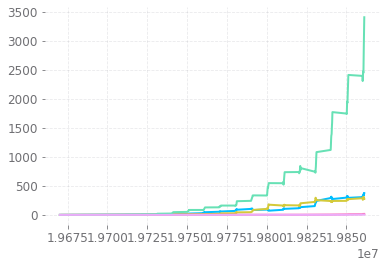

In [64]:
plt.plot(np.cumprod(1+Factors.T))

In [170]:
xTrain.index.get_level_values(1).unique() < 19671130

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [173]:
xTrain.index.get_level_values(1).unique()

Int64Index([19670131, 19670228, 19670331, 19670428, 19670531, 19670630,
            19670731, 19670831, 19670929, 19671031,
            ...
            19860331, 19860430, 19860530, 19860630, 19860731, 19860829,
            19860930, 19861031, 19861128, 19861231],
           dtype='int64', length=240)

In [174]:
xTrain.index.get_level_values(1).unique()[10]

19671130

In [200]:
def rollingIPCA(X, y, k=5, burnin=10):
    gammas = []
    factors = []
    regrs = []
    dates = []
    xindex = X.index.get_level_values(1)
    for date in tqdm(xindex.unique()[burnin:]):
        regr = InstrumentedPCA(n_factors=k, intercept=False)
        window = (xindex < date)
        regr = regr.fit(X[window], y[window])
        Gamma, Factors = regr.get_factors(label_ind=True)
        gammas.append(Gamma)
        factors.append(Factors)
        regrs.append(regr)
        dates.append(date)
    return gammas, factors, regrs, dates

gamfactors = rollingIPCA(xVal, yVal)

The panel dimensions are:
n_samples: 2245 , L: 46 , T: 10


[=========================================================================] 100%


Step 1 - Aggregate Update: 0.6446831323254925
Step 2 - Aggregate Update: 0.15817585728756345
Step 3 - Aggregate Update: 0.7620572257537045
Step 4 - Aggregate Update: 0.8759953057581328
Step 5 - Aggregate Update: 0.05706697276296828
Step 6 - Aggregate Update: 0.026101981969351228
Step 7 - Aggregate Update: 0.016605667598936863
Step 8 - Aggregate Update: 0.014926836453584377
Step 9 - Aggregate Update: 0.013157225928433488
Step 10 - Aggregate Update: 0.011437934881608075
Step 11 - Aggregate Update: 0.009886160137091277
Step 12 - Aggregate Update: 0.008532558307858432
Step 13 - Aggregate Update: 0.007369733965204021
Step 14 - Aggregate Update: 0.006376494809207073
Step 15 - Aggregate Update: 0.005528784618325493
Step 16 - Aggregate Update: 0.004804087820443902
Step 17 - Aggregate Update: 0.0041828509606292585
Step 18 - Aggregate Update: 0.0036486422463751014
Step 19 - Aggregate Update: 0.0031878411686622338
Step 20 - Aggregate Update: 0.0027892021881753062
Step 21 - Aggregate Update: 0.002

Step 55 - Aggregate Update: 3.390586187451694e-05
Step 56 - Aggregate Update: 2.9945340184703295e-05
Step 57 - Aggregate Update: 2.644774637661218e-05
Step 58 - Aggregate Update: 2.3358904750733767e-05
Step 59 - Aggregate Update: 2.0630994218853727e-05
Step 60 - Aggregate Update: 1.8221799607767708e-05
Step 61 - Aggregate Update: 1.6094052206538922e-05
Step 62 - Aggregate Update: 1.4214848197482977e-05
Step 63 - Aggregate Update: 1.2555135802241879e-05
Step 64 - Aggregate Update: 1.10892633802262e-05
Step 65 - Aggregate Update: 9.794580372271544e-06
-- Convergence Reached --
The panel dimensions are:
n_samples: 2253 , L: 46 , T: 11


[=========================================================================] 100%


Step 1 - Aggregate Update: 0.7410056230746667
Step 2 - Aggregate Update: 0.657107189718317
Step 3 - Aggregate Update: 0.11851210589170116
Step 4 - Aggregate Update: 0.07509147840322153
Step 5 - Aggregate Update: 0.06002185665775287
Step 6 - Aggregate Update: 0.04559126326674152
Step 7 - Aggregate Update: 0.035224754140024336
Step 8 - Aggregate Update: 0.02860734712902352
Step 9 - Aggregate Update: 0.026954330625403478
Step 10 - Aggregate Update: 0.02606956606640852
Step 11 - Aggregate Update: 0.026832313890934996
Step 12 - Aggregate Update: 0.02752469616151894
Step 13 - Aggregate Update: 0.027838568812938894
Step 14 - Aggregate Update: 0.027513081237818964
Step 15 - Aggregate Update: 0.029997643171716576
Step 16 - Aggregate Update: 0.03761661058632204
Step 17 - Aggregate Update: 0.06773874729187192
Step 18 - Aggregate Update: 0.1721017530014135
Step 19 - Aggregate Update: 0.9835741891306782
Step 20 - Aggregate Update: 0.08815068812247767
Step 21 - Aggregate Update: 0.03442257638515084


 49 - Aggregate Update: 0.00015004395034807355
Step 50 - Aggregate Update: 0.00012764041938963244
Step 51 - Aggregate Update: 0.0001085594843004134
Step 52 - Aggregate Update: 9.231460128771712e-05
Step 53 - Aggregate Update: 7.848874140154588e-05
Step 54 - Aggregate Update: 6.672494931459633e-05
Step 55 - Aggregate Update: 5.671804116871154e-05
Step 56 - Aggregate Update: 4.82073478741199e-05
Step 57 - Aggregate Update: 4.0970403754773954e-05
Step 58 - Aggregate Update: 3.4817478193803486e-05
Step 59 - Aggregate Update: 2.958685377324466e-05
Step 60 - Aggregate Update: 2.5140758343367153e-05
Step 61 - Aggregate Update: 2.1361869080506468e-05
Step 62 - Aggregate Update: 1.81503133684785e-05
Step 63 - Aggregate Update: 1.5421099235059244e-05
Step 64 - Aggregate Update: 1.310191708545766e-05
Step 65 - Aggregate Update: 1.113126125444619e-05
Step 66 - Aggregate Update: 9.456825355594334e-06
-- Convergence Reached --
The panel dimensions are:
n_samples: 2295 , L: 46 , T: 12


[=========================================================================] 100%


Step 1 - Aggregate Update: 0.7439996636860952
Step 2 - Aggregate Update: 0.13410041146317397
Step 3 - Aggregate Update: 0.08464089142465225
Step 4 - Aggregate Update: 0.055161638797397244
Step 5 - Aggregate Update: 0.051093839613958116
Step 6 - Aggregate Update: 0.16972964845494248
Step 7 - Aggregate Update: 0.7795302221402876
Step 8 - Aggregate Update: 0.08003651645607804
Step 9 - Aggregate Update: 0.04058359278153826
Step 10 - Aggregate Update: 0.03402416402307819
Step 11 - Aggregate Update: 0.030525901686978107
Step 12 - Aggregate Update: 0.027925216142671266
Step 13 - Aggregate Update: 0.025548899237003403
Step 14 - Aggregate Update: 0.025359211290230804
Step 15 - Aggregate Update: 0.025652276767787974
Step 16 - Aggregate Update: 0.025805469748290427
Step 17 - Aggregate Update: 0.025861069237851364
Step 18 - Aggregate Update: 0.025873380333888474
Step 19 - Aggregate Update: 0.025894107326456237
Step 20 - Aggregate Update: 0.02596356634625084
Step 21 - Aggregate Update: 0.9084999123

Step 73 - Aggregate Update: 1.2137259256334021e-05
Step 74 - Aggregate Update: 9.94806995872205e-06
-- Convergence Reached --
The panel dimensions are:
n_samples: 2318 , L: 46 , T: 13


[=========================================================================] 100%


Step 1 - Aggregate Update: 0.5429353823082806
Step 2 - Aggregate Update: 0.1005758159236948
Step 3 - Aggregate Update: 0.1042867277352611
Step 4 - Aggregate Update: 0.08603756993647077
Step 5 - Aggregate Update: 0.05689173663949583
Step 6 - Aggregate Update: 0.8155720716917241
Step 7 - Aggregate Update: 0.03378130225590585
Step 8 - Aggregate Update: 0.026415721923117585
Step 9 - Aggregate Update: 0.020139274402734636
Step 10 - Aggregate Update: 0.01718666965815202
Step 11 - Aggregate Update: 0.014867051130511302
Step 12 - Aggregate Update: 0.012777920455532235
Step 13 - Aggregate Update: 0.010883078301992505
Step 14 - Aggregate Update: 0.009176063416697404
Step 15 - Aggregate Update: 0.007659741171329622
Step 16 - Aggregate Update: 0.006335126110324548
Step 17 - Aggregate Update: 0.005196973762958551
Step 18 - Aggregate Update: 0.004233595636594558
Step 19 - Aggregate Update: 0.0034286321652825004
Step 20 - Aggregate Update: 0.0027632763153461817
Step 21 - Aggregate Update: 0.002218188

Step 39 - Aggregate Update: 3.3334495386300005e-05
Step 40 - Aggregate Update: 2.6289021557617323e-05
Step 41 - Aggregate Update: 2.0730116357896462e-05
Step 42 - Aggregate Update: 1.6344882314864133e-05
Step 43 - Aggregate Update: 1.2886046798846196e-05
Step 44 - Aggregate Update: 1.0158272481304575e-05
Step 45 - Aggregate Update: 8.007299655619741e-06
-- Convergence Reached --
The panel dimensions are:
n_samples: 2325 , L: 46 , T: 14


[=========================================================================] 100%


Step 1 - Aggregate Update: 0.5763353015795135
Step 2 - Aggregate Update: 1.1655016317146663
Step 3 - Aggregate Update: 0.08142255472248464
Step 4 - Aggregate Update: 0.06511543031748639
Step 5 - Aggregate Update: 0.05324733998567375
Step 6 - Aggregate Update: 0.04772916289210158
Step 7 - Aggregate Update: 0.044077731206635086
Step 8 - Aggregate Update: 0.03983875018972961
Step 9 - Aggregate Update: 0.035470380047850594
Step 10 - Aggregate Update: 1.1434115246960137
Step 11 - Aggregate Update: 0.026501244062454687
Step 12 - Aggregate Update: 0.022212407487460478
Step 13 - Aggregate Update: 0.7703396425176967
Step 14 - Aggregate Update: 0.01511322013214389
Step 15 - Aggregate Update: 0.013589512596252545
Step 16 - Aggregate Update: 0.012038495420562595
Step 17 - Aggregate Update: 0.010535504625533265
Step 18 - Aggregate Update: 0.009127284147607523
Step 19 - Aggregate Update: 0.007839970353692993
Step 20 - Aggregate Update: 0.006685330196600989
Step 21 - Aggregate Update: 0.0056653221649

 10%|████▍                                       | 5/50 [00:05<00:43,  1.04it/s]

Step 40 - Aggregate Update: 0.0001511351203577066
Step 41 - Aggregate Update: 0.0001238655710029124
Step 42 - Aggregate Update: 0.00010149828975021535
Step 43 - Aggregate Update: 8.315746147627423e-05
Step 44 - Aggregate Update: 6.812205690409634e-05
Step 45 - Aggregate Update: 5.5799002357970195e-05
Step 46 - Aggregate Update: 4.570083285994342e-05
Step 47 - Aggregate Update: 3.7427134801357176e-05
Step 48 - Aggregate Update: 3.064917113344834e-05
Step 49 - Aggregate Update: 2.509716873191903e-05
Step 50 - Aggregate Update: 2.0549824036403264e-05
Step 51 - Aggregate Update: 1.682565106954359e-05
Step 52 - Aggregate Update: 1.377585680117921e-05
Step 53 - Aggregate Update: 1.1278479065415792e-05
Step 54 - Aggregate Update: 9.233567413099997e-06
-- Convergence Reached --


The panel dimensions are:
n_samples: 2339 , L: 46 , T: 15


[=========================================================================] 100%


Step 1 - Aggregate Update: 0.5824943405319993
Step 2 - Aggregate Update: 0.1390561020513349
Step 3 - Aggregate Update: 0.06595829729605229
Step 4 - Aggregate Update: 0.023825770954082892
Step 5 - Aggregate Update: 0.013919165183200924
Step 6 - Aggregate Update: 0.03406875624048822
Step 7 - Aggregate Update: 0.06348739314747609
Step 8 - Aggregate Update: 0.09227992499062432
Step 9 - Aggregate Update: 0.10605840152869905
Step 10 - Aggregate Update: 0.10102387004151764
Step 11 - Aggregate Update: 0.0704935039440796
Step 12 - Aggregate Update: 0.044527393199420784
Step 13 - Aggregate Update: 0.02815091547886986
Step 14 - Aggregate Update: 0.01826632546578083
Step 15 - Aggregate Update: 0.012176794937355642
Step 16 - Aggregate Update: 0.008303471057236458
Step 17 - Aggregate Update: 0.0057656187962989575
Step 18 - Aggregate Update: 0.004061327875509474
Step 19 - Aggregate Update: 0.002893905946538558
Step 20 - Aggregate Update: 0.002081421459838667
Step 21 - Aggregate Update: 0.001508646017

Step 38 - Aggregate Update: 1.0799317634313521e-05
Step 39 - Aggregate Update: 8.188213982324166e-06
-- Convergence Reached --
The panel dimensions are:
n_samples: 2358 , L: 46 , T: 16


[=========================================================================] 100%


Step 1 - Aggregate Update: 0.5523944266738191
Step 2 - Aggregate Update: 0.18358185556949053
Step 3 - Aggregate Update: 0.09361500686503832
Step 4 - Aggregate Update: 0.038476788789583355
Step 5 - Aggregate Update: 0.015327703169600082
Step 6 - Aggregate Update: 0.0069999524264293955
Step 7 - Aggregate Update: 0.0051627321251405955
Step 8 - Aggregate Update: 0.0037587308637209993
Step 9 - Aggregate Update: 0.0027176130912578422
Step 10 - Aggregate Update: 0.001962339919126699
Step 11 - Aggregate Update: 0.0014193237351599747
Step 12 - Aggregate Update: 0.0010298144699321943
Step 13

 - Aggregate Update: 0.0007501159444038841
Step 14 - Aggregate Update: 0.0005487089727082561
Step 15 - Aggregate Update: 0.0004031460025847866
Step 16 - Aggregate Update: 0.00029750884815411827
Step 17 - Aggregate Update: 0.00022051187601986044
Step 18 - Aggregate Update: 0.00016413918174512654
Step 19 - Aggregate Update: 0.00012268071528127866
Step 20 - Aggregate Update: 9.20546447535503e-05
Step 21 - Aggregate Update: 6.933165270293917e-05
Step 22 - Aggregate Update: 5.240073952628155e-05
Step 23 - Aggregate Update: 3.9733988589377156e-05
Step 24 - Aggregate Update: 3.0220555221421863e-05
Step 25 - Aggregate Update: 2.3049145898360046e-05
Step 26 - Aggregate Update: 1.7624537053034794e-05
Step 27 - Aggregate Update: 1.3508050626567791e-05
Step 28 - Aggregate Update: 1.037494216192536e-05
Step 29 - Aggregate Update: 7.983767407404585e-06
-- Convergence Reached --
The panel dimensions are:
n_samples: 2380 , L: 46 , T: 17


[=========================================================================] 100%


Step 1 - Aggregate Update: 0.5505128905761812
Step 2 - Aggregate Update: 0.24300341269261017
Step 3 - Aggregate Update: 0.11002433474146298
Step 4 - Aggregate Update: 0.0497777323242725
Step 5 - Aggregate Update: 0.025106767092959573
Step 6 - Aggregate Update: 0.014749844934030712
Step 7 - Aggregate Update: 0.009302905348176876
Step 8 - Aggregate Update: 0.006149639489656258
Step 9 - Aggregate Update: 0.004183923565591829
Step 10 - Aggregate Update: 0.0028935381998532322
Step 11 - Aggregate Update: 0.0020183788886777576
Step 12 - Aggregate Update: 0.0014136326679967254
Step 13 - Aggregate Update: 0.0009916750385564888


 16%|███████                                     | 8/50 [00:07<00:37,  1.11it/s]

Step 14 - Aggregate Update: 0.0006959527787948061
Step 15 - Aggregate Update: 0.0004883725764983776
Step 16 - Aggregate Update: 0.0003426347548127484
Step 17 - Aggregate Update: 0.00024035408804498615
Step 18 - Aggregate Update: 0.0001686097672451703
Step 19 - Aggregate Update: 0.00011830771063371659
Step 20 - Aggregate Update: 8.304928872022999e-05
Step 21 - Aggregate Update: 5.8337138914052455e-05
Step 22 - Aggregate Update: 4.101408374290738e-05
Step 23 - Aggregate Update: 2.886624145014005e-05
Step 24 - Aggregate Update: 2.0398377866909234e-05
Step 25 - Aggregate Update: 1.4770340617475952e-05
Step 26 - Aggregate Update: 1.0733405925139605e-05
Step 27 - Aggregate Update: 7.828792921535377e-06
-- Convergence Reached --


The panel dimensions are:
n_samples: 2397 , L: 46 , T: 18


[=========================================================================] 100%


Step 1 - Aggregate Update: 0.5498192057961945
Step 2 - Aggregate Update: 0.24870664970827366
Step 3 - Aggregate Update: 0.1286411741720286
Step 4 - Aggregate Update: 0.05986528759866794
Step 5 - Aggregate Update: 0.033152545145844134
Step 6 - Aggregate Update: 0.021288974171519905
Step 7 - Aggregate Update: 1.2315633064890408
Step 8 - Aggregate Update: 0.01044055633749804
Step 9 - Aggregate Update: 0.007521977266562417
Step 10 - Aggregate Update: 0.005429039688159075
Step 11 - Aggregate Update: 0.0039089564559708235
Step

 18%|███████▉                                    | 9/50 [00:08<00:36,  1.11it/s]

 12 - Aggregate Update: 0.0028036611805133827
Step 13 - Aggregate Update: 0.0020026543647907093
Step 14 - Aggregate Update: 0.0014248258332747264
Step 15 - Aggregate Update: 0.0010098877916877146
Step 16 - Aggregate Update: 0.000713147957574759
Step 17 - Aggregate Update: 0.0005017153545038744
Step 18 - Aggregate Update: 0.0003515688526734089
Step 19 - Aggregate Update: 0.000245281768906517
Step 20 - Aggregate Update: 0.00017027983485045457
Step 21 - Aggregate Update: 0.00011752912368408631
Step 22 - Aggregate Update: 8.05616889015758e-05
Step 23 - Aggregate Update: 5.475996333232074e-05
Step 24 - Aggregate Update: 3.683555861275917e-05
Step 25 - Aggregate Update: 2.530818085867345e-05
Step 26 - Aggregate Update: 1.987615401145837e-05
Step 27 - Aggregate Update: 1.5629990235983132e-05
Step 28 - Aggregate Update: 1.2305558028530283e-05
Step 29 - Aggregate Update: 9.698908581313309e-06
-- Convergence Reached --


The panel dimensions are:
n_samples: 2454 , L: 46 , T: 19


[=========================================================================] 100%


Step 1 - Aggregate Update: 0.5800082515540976
Step 2 - Aggregate Update: 0.20856090715627024
Step 3 - Aggregate Update: 0.09625513216102427
Step 4 - Aggregate Update: 0.050137644217420785
Step 5 - Aggregate Update: 0.02796965171704212
Step 6 - Aggregate Update: 0.0176579484591554
Step 7 - Aggregate Update: 0.0116938007675427
Step 8 - Aggregate Update: 0.007989669715935316
Step 9 - Aggregate Update: 0.005558434443152474
Step 10 - Aggregate Update: 0.0039042189973720054
Step 11 - Aggregate Update: 0.0027550965929628857
Step 12 - Aggregate Update: 0.001948143320513386
Step 13 - Aggregate Update: 0.0013785506188499427


 20%|████████▌                                  | 10/50 [00:09<00:34,  1.17it/s]

Step 14 - Aggregate Update: 0.0009756345471531938
Step 15 - Aggregate Update: 0.0006904206654810632
Step 16 - Aggregate Update: 0.0004885101152302465
Step 17 - Aggregate Update: 0.00034559421555899195
Step 18 - Aggregate Update: 0.0002444561045336288
Step 19 - Aggregate Update: 0.00017289585016554143
Step 20 - Aggregate Update: 0.00012227035918530027
Step 21 - Aggregate Update: 8.645887348546905e-05
Step 22 - Aggregate Update: 6.112854087379077e-05
Step 23 - Aggregate Update: 4.3213058945008875e-05
Step 24 - Aggregate Update: 3.054286600191747e-05
Step 25 - Aggregate Update: 2.1583058967308832e-05
Step 26 - Aggregate Update: 1.5247793993762582e-05
Step 27 - Aggregate Update: 1.0768920139313243e-05
Step 28 - Aggregate Update: 7.603030379443876e-06
-- Convergence Reached --


The panel dimensions are:
n_samples: 2488 , L: 46 , T: 20


[=========================================================================] 100%


Step 1 - Aggregate Update: 0.577823955553775
Step 2 - Aggregate Update: 0.16517901712078387
Step 3 - Aggregate Update: 0.09804631348524862
Step 4 - Aggregate Update: 0.8928408178829801
Step 5 - Aggregate Update: 0.027610845483834745
Step 6 - Aggregate Update: 0.017365255358707296
Step 7 - Aggregate Update: 0.011386790361819055
Step 8 - Aggregate Update: 0.007674374707243553
Step 9 - Aggregate Update: 0.005259591261607827
Step 10 - Aggregate Update: 0.003639960833436956
Step 11 - Aggregate Update: 0.002533140663317744
Step 12 - Aggregate Update: 0.0017684866795971768
Step 13 - Aggregate Update: 0.0012369225184776442
Step 14 - Aggregate Update: 0.000866064933503212
Step 15 - Aggregate Update: 0.000606773036957442
Step 16 - Aggregate Update: 0.0004252428426584423
Step 17 - Aggregate Update: 0.0002980450835630352
Step 18 - Aggregate Update: 0.00020886952504417522
Step 19 - Aggregate Update: 0.0001463308790138826
Step 20 - Aggregate Update: 0.00010246726352064472
Step 21 - Aggregate Update:

Step 27 - Aggregate Update: 8.19847884783037e-06
-- Convergence Reached --
The panel dimensions are:
n_samples: 2524 , L: 46 , T: 21


[=========================================================================] 100%


Step 1 - Aggregate Update: 0.5498574845140158
Step 2 - Aggregate Update: 0.12456392808801364
Step 3 - Aggregate Update: 0.05839871344708902
Step 4 - Aggregate Update: 0.02703908882807657
Step 5 - Aggregate Update: 0.013943298873058896
Step 6 - Aggregate Update: 0.01038907947435705
Step 7 - Aggregate Update: 0.0077866955872750165
Step 8 - Aggregate Update: 0.005659102353751944
Step 9 - Aggregate Update: 0.004037762357560579
Step 10 - Aggregate Update: 0.0028465883063366754
Step 11 - Aggregate Update: 0.001989622776488925
Step 12 - Aggregate Update: 0.0013810660694918153
Step 13 - Aggregate Update: 0.000961889509673769
Step 14 - Aggregate Update: 0.0006851992804568913
Step 15 - Aggregate Update: 0.0004847372125063726
Step 16 - Aggregate Update: 0.00034070666871351823
Step 17 - Aggregate Update: 0.00023792910880846702
Step 18 - Aggregate Update: 0.00016503162248118763
Step 19 - Aggregate Update: 0.0001136206344606594
Step 20 - Aggregate Update: 8.20788836810582e-05
Step 21 - Aggregate Upd

Step 28 - Aggregate Update: 1.3117220395902907e-05
Step 29 - Aggregate Update: 1.0421683589396935e-05
Step 30 - Aggregate Update: 8.27672645390548e-06
-- Convergence Reached --
The panel dimensions are:
n_samples: 2548 , L: 46 , T: 22


[=========================================================================] 100%


Step 1 - Aggregate Update: 0.5620225525291411
Step 2 - Aggregate Update: 0.36770088018833547
Step 3 - Aggregate Update: 0.07313188441493679
Step 4 - Aggregate Update: 0.04520343257316991
Step 5 - Aggregate Update: 0.029387426056732252
Step 6 - Aggregate Update: 0.019700372991212023
Step 7 - Aggregate Update: 0.016186351022556472
Step 8 - Aggregate Update: 0.013194828972413017
Step 9 - Aggregate Update: 0.010595441678413406
Step 10 - Aggregate Update: 0.008386510588687321
Step 11 - Aggregate Update: 0.00656693494845724
Step 12 - Aggregate Update: 0.00510783785858987
Step 13 - Aggregate Update: 0.0039605152505835794
Step 14 - Aggregate Update: 0.0030698214108007826
Step 15 - Aggregate Update: 0.002383419193084005
Step 16 - Aggregate Update: 0.0018561747696730219
Step 17 - Aggregate Update: 0.001451305388101759
Step 18 - Aggregate Update: 0.0011398505071597287
Step 19 - Aggregate Update: 0.0009113745473974255
Step 20 - Aggregate Update: 0.0007855604470324851
Step 21 - Aggregate Update: 0.

Step 42 - Aggregate Update: 1.7151977501794757e-05
Step 43 - Aggregate Update: 1.4300142266943094e-05
Step 44 - Aggregate Update: 1.1920668022191716e-05
Step 45 - Aggregate Update: 9.935821686846147e-06
-- Convergence Reached --
The panel dimensions are:
n_samples: 2579 , L: 46 , T: 23


[=========================================================================] 100%


Step 1 - Aggregate Update: 0.6705501505158926
Step 2 - Aggregate Update: 0.4062176733937467
Step 3 - Aggregate Update: 0.07475895203050878
Step 4 - Aggregate Update: 0.05098511775390058
Step 5 - Aggregate Update: 0.036591827717214254
Step 6 - Aggregate Update: 0.027177816565357255
Step 7 - Aggregate Update: 0.020791599962505687
Step 8 - Aggregate Update: 0.01577354350998829
Step 9 - Aggregate Update: 0.011781187324018363
Step 10 - Aggregate Update: 1.0548850984646454
Step 11 - Aggregate Update: 0.006345522307337724
Step 12 - Aggregate Update: 0.004602191957504109
Step 13 - Aggregate Update: 0.003321129945745134
Step 14 - Aggregate Update: 0.0023881398191728936
Step 15 - Aggregate Update: 0.001712868148279742
Step 16 - Aggregate Update: 0.0012262342256964195
Step 17 - Aggregate Update: 0.0009011984790849858
Step 18 - Aggregate Update: 0.0007402547207050192
Step 19 - Aggregate Update: 0.0006084702244524842
Step 20 - Aggregate Update: 0.0005003626689989438
Step 21 - Aggregate Update: 0.00

Step 28 - Aggregate Update: 0.00011847467764358743
Step 29 - Aggregate Update: 9.843180260044049e-05
Step 30 - Aggregate Update: 8.165978781815575e-05
Step 31 - Aggregate Update: 6.765984962670002e-05
Step 32 - Aggregate Update: 5.5998723003714e-05
Step 33 - Aggregate Update: 4.630343373790424e-05
Step 34 - Aggregate Update: 3.825523948858267e-05
Step 35 - Aggregate Update: 3.158336198871847e-05
Step 36 - Aggregate Update: 2.605890002999045e-05
Step 37 - Aggregate Update: 2.1489146019348926e-05
Step 38 - Aggregate Update: 1.7712421237714437e-05
Step 39 - Aggregate Update: 1.459347446308712e-05
Step 40 - Aggregate Update: 1.2019441440913603e-05
Step 41 - Aggregate Update: 9.896337529069488e-06
-- Convergence Reached --
The panel dimensions are:
n_samples: 2611 , L: 46 , T: 24


[=========================================================================] 100%


Step 1 - Aggregate Update: 0.6722822486290703
Step 2 - Aggregate Update: 0.4504785722765006
Step 3 - Aggregate Update: 0.07339991115224392
Step 4 - Aggregate Update: 0.051070300368545096
Step 5 - Aggregate Update: 0.03844259121396168
Step 6 - Aggregate Update: 0.029607563859428088
Step 7 - Aggregate Update: 0.022616926382827862
Step 8 - Aggregate Update: 0.016971735673218108
Step 9 - Aggregate Update: 1.0484011500816537
Step 10 - Aggregate Update: 0.009231802066870652
Step 11 - Aggregate Update: 0.0067337598517498015
Step 12 - Aggregate Update: 0.004881302359136336
Step 13 - Aggregate Update: 0.003524149406222553
Step 14 - Aggregate Update: 0.0025377147641449313
Step 15 - Aggregate Update: 0.0018244299420927673
Step 16 - Aggregate Update: 0.0013103840616776746
Step 17 - Aggregate Update: 0.0010163101089012694
Step 18 - Aggregate Update: 0.0008364453878043077
Step 19 - Aggregate Update: 0.0006888873623120406
Step 20 - Aggregate Update: 0.0005675998077320221
Step 21 - Aggregate Update: 0

Step 42 - Aggregate Update: 9.760125758762062e-06
-- Convergence Reached --
The panel dimensions are:
n_samples: 2656 , L: 46 , T: 25


[=========================================================================] 100%


Step 1 - Aggregate Update: 0.6847275753263669
Step 2 - Aggregate Update: 0.40176760493183683
Step 3 - Aggregate Update: 0.12185006678447655
Step 4 - Aggregate Update: 0.03345651546906425
Step 5 - Aggregate Update: 0.03394246066074827
Step 6 - Aggregate Update: 0.03316783190792075
Step 7 - Aggregate Update: 0.8713389666249391
Step 8 - Aggregate Update: 0.028362209821427897
Step 9 - Aggregate Update: 0.02473472082054722
Step 10 - Aggregate Update: 0.02086010321960278
Step 11 - Aggregate Update: 0.017143390989937408
Step 12 - Aggregate Update: 0.013832280557394428
Step 13 - Aggregate Update: 0.011024859527573028
Step 14 - Aggregate Update: 0.008720206663637833
Step 15 - Aggregate Update: 0.0068670301504838785
Step 16 - Aggregate Update: 0.005396079409256391
Step 17 - Aggregate Update: 0.004237670481759617
Step 18 - Aggregate Update: 0.0033294984138869527
Step 19 - Aggregate Update: 0.002619119652068125
Step 20 - Aggregate Update: 0.002063871998413652
Step 21 - Aggregate Update: 0.00162974

 32%|█████████████▊                             | 16/50 [00:15<00:34,  1.02s/it]

Step 39 - Aggregate Update: 3.545883394569238e-05
Step 40 - Aggregate Update: 2.9216274101948048e-05
Step 41 - Aggregate Update: 2.410303206139275e-05
Step 42 - Aggregate Update: 1.9907653615064413e-05
Step 43 - Aggregate Update: 1.6459917442993022e-05
Step 44 - Aggregate Update: 1.3622432439741594e-05
Step 45 - Aggregate Update: 1.1284024693275496e-05
Step 46 - Aggregate Update: 9.354515103088268e-06
-- Convergence Reached --


The panel dimensions are:
n_samples: 2671 , L: 46 , T: 26


[=========================================================================] 100%


Step 1 - Aggregate Update: 0.8118867659051789
Step 2 - Aggregate Update: 0.3806469461277657
Step 3 - Aggregate Update: 0.8787384392306732
Step 4 - Aggregate Update: 0.035341695524210015
Step 5 - Aggregate Update: 0.026903762337323722
Step 6 - Aggregate Update: 0.025189227442772938
Step 7 - Aggregate Update: 0.8459598959856149
Step 8 - Aggregate Update: 0.019836212228947755
Step 9 - Aggregate Update: 0.01678292147365168
Step 10 - Aggregate Update: 0.013852054262787794
Step 11 - Aggregate Update: 0.011219414496066248
Step 12 - Aggregate Update: 0.008964389485270528
Step 13 - Aggregate Update: 0.007096196646918716
Step 14 - Aggregate Update: 0.005583784998363237
Step 15 - Aggregate Update: 0.004378494055903296
Step 16 - Aggregate Update: 0.0034279684440240293
Step 17 - Aggregate Update: 0.0026833815726956083
Step 18 - Aggregate Update: 0.0021024491802732175
Step 19 - Aggregate Update: 0.001650115002398497
Step 20 - Aggregate Update: 0.001298100562088891
Step 21 - Aggregate Update: 0.00102

Step 39 - Aggregate Update: 2.4324334846460068e-05
Step 40 - Aggregate Update: 2.0203727206566987e-05
Step 41 - Aggregate Update: 1.6803185861101813e-05
Step 42 - Aggregate Update: 1.3991580897513775e-05
Step 43 - Aggregate Update: 1.166289995509608e-05
Step 44 - Aggregate Update: 9.731159801189878e-06
-- Convergence Reached --
The panel dimensions are:
n_samples: 2688 , L: 46 , T: 27


[=========================================================================] 100%


Step 1 - Aggregate Update: 0.5908684464259004
Step 2 - Aggregate Update: 0.8238936242922688
Step 3 - Aggregate Update: 0.07273210534213403
Step 4 - Aggregate Update: 0.042301571504313934
Step 5 - Aggregate Update: 0.03570023511349345
Step 6 - Aggregate Update: 0.029104941572934626
Step 7 - Aggregate Update: 0.9656940663992802
Step 8 - Aggregate Update: 0.01848047692110624
Step 9 - Aggregate Update: 0.014564865404109877
Step 10 - Aggregate Update: 0.011437872105895922
Step 11 - Aggregate Update: 0.008965588163663801
Step 12 - Aggregate Update: 0.007023925535076608
Step 13 - Aggregate Update: 0.005505442169422725
Step 14 - Aggregate Update: 0.004320712039637457
Step 15 - Aggregate Update: 0.0033972221734953414
Step 16 - Aggregate Update: 0.0026772200397531254
Step 17 - Aggregate Update: 0.00211527347274193
Step 18 - Aggregate Update: 0.0016759385267528099
Step 19 - Aggregate Update: 0.0013317118702095704
Step 20 - Aggregate Update: 0.0010613201084264529
Step 21 - Aggregate Update: 0.0008

 36%|███████████████▍                           | 18/50 [00:17<00:34,  1.08s/it]

Step 37 - Aggregate Update: 3.234969295644319e-05
Step 38 - Aggregate Update: 2.672568639576489e-05
Step 39 - Aggregate Update: 2.209849879226955e-05
Step 40 - Aggregate Update: 1.8286723518265435e-05
Step 41 - Aggregate Update: 1.5156714889184852e-05
Step 42 - Aggregate Update: 1.2576082448013948e-05
Step 43 - Aggregate Update: 1.0439652229375651e-05
Step 44 - Aggregate Update: 8.669719866821746e-06
-- Convergence Reached --


The panel dimensions are:
n_samples: 2705 , L: 46 , T: 28


[=========================================================================] 100%


Step 1 - Aggregate Update: 0.5947749700038726
Step 2 - Aggregate Update: 0.8001835877152412
Step 3 - Aggregate Update: 0.07561297924557983
Step 4 - Aggregate Update: 0.043871057353577755
Step 5 - Aggregate Update: 0.931538842374251
Step 6 - Aggregate Update: 0.02903955376450823
Step 7 - Aggregate Update: 0.02591666300612927
Step 8 - Aggregate Update: 0.022366413011072173
Step 9 - Aggregate Update: 0.01873502972076818
Step 10 - Aggregate Update: 0.015364482973642679
Step 11 - Aggregate Update: 0.012436575714882186
Step 12 - Aggregate Update: 0.009995582369159539
Step 13 - Aggregate Update: 0.008008984222287102
Step 14 - Aggregate Update: 0.006413616354926904
Step 15 - Aggregate Update: 0.00514103725036924
Step 16 - Aggregate Update: 0.004128743032726395
Step 17 - Aggregate Update: 0.00332382270646725
Step 18 - Aggregate Update: 0.0026831594526922214
Step 19 - Aggregate Update: 0.002172306397825452
Step 20 - Aggregate Update: 0.00176402003748527
Step 21 - Aggregate Update: 0.001436855876

Step 51 - Aggregate Update: 1.1772248970309818e-05
Step 52 - Aggregate Update: 1.0126990163110416e-05
Step 53 - Aggregate Update: 8.740146729812465e-06
-- Convergence Reached --
The panel dimensions are:
n_samples: 2717 , L: 46 , T: 29


[=========================================================================] 100%


Step 1 - Aggregate Update: 0.6072556765176478
Step 2 - Aggregate Update: 0.7624611447598332
Step 3 - Aggregate Update: 0.10146757117422105
Step 4 - Aggregate Update: 0.04747716934195668
Step 5 - Aggregate Update: 0.9980275890479754
Step 6 - Aggregate Update: 0.04068817525225238
Step 7 - Aggregate Update: 0.03687392859063743
Step 8 - Aggregate Update: 0.03155909438813009
Step 9 - Aggregate Update: 0.025888627729131114
Step 10 - Aggregate Update: 0.020674848327723844
Step 11 - Aggregate Update: 1.0877274141997937
Step 12 - Aggregate Update: 0.012693736587526996
Step 13 - Aggregate Update: 0.009876089875894667
Step 14 - Aggregate Update: 0.007678122050471289
Step 15 - Aggregate Update: 0.00597286092538199
Step 16 - Aggregate Update: 0.004652274775903686
Step 17 - Aggregate Update: 0.0036294899234300543
Step 18 - Aggregate Update: 0.0028364984629924914
Step 19 - Aggregate Update: 0.002220728058987445
Step 20 - Aggregate Update: 0.0017417517570147215
Step 21 - Aggregate Update: 0.0013685257

Step 47 - Aggregate Update: 1.2834610713710268e-05
Step 48 - Aggregate Update: 1.1148870684759421e-05
Step 49 - Aggregate Update: 9.677624065463838e-06
-- Convergence Reached --
The panel dimensions are:
n_samples: 2732 , L: 46 , T: 30


[=========================================================================] 100%


Step 1 - Aggregate Update: 0.7884497328474576
Step 2 - Aggregate Update: 0.17571912821179125
Step 3 - Aggregate Update: 0.234187925607991
Step 4 - Aggregate Update: 0.8220997102226637
Step 5 - Aggregate Update: 0.9992999768353461
Step 6 - Aggregate Update: 0.03449058001461475
Step 7 - Aggregate Update: 0.03141549874983085
Step 8 - Aggregate Update: 0.0271500902097159
Step 9 - Aggregate Update: 0.0224928802375699
Step 10 - Aggregate Update: 0.018110456441139594
Step 11 - Aggregate Update: 0.014334335485101962
Step 12 - Aggregate Update: 0.011242450608454108
Step 13 - Aggregate Update: 0.008782614438558864
Step 14 - Aggregate Update: 1.0850982314895146
Step 15 - Aggregate Update: 0.005358265066173096
Step 16 - Aggregate Update: 0.004197969390402803
Step 17 - Aggregate Update: 0.0034936561033183655
Step 18 - Aggregate Update: 0.002986291956894732
Step 19 - Aggregate Update: 0.002569178524840482
Step 20 - Aggregate Update: 0.002224119648504691
Step 21 - Aggregate Update: 0.0019367355372697

 42%|██████████████████                         | 21/50 [00:22<00:40,  1.41s/it]

Step 71 - Aggregate Update: 2.5774095270429676e-05
Step 72 - Aggregate Update: 2.3518945591667617e-05
Step 73 - Aggregate Update: 2.1461155696379797e-05
Step 74 - Aggregate Update: 1.9583448987781082e-05
Step 75 - Aggregate Update: 1.7870061481135846e-05
Step 76 - Aggregate Update: 1.6306609526429983e-05
Step 77 - Aggregate Update: 1.4879968767478324e-05
Step 78 - Aggregate Update: 1.357816413268681e-05
Step 79 - Aggregate Update: 1.2390269084575078e-05
Step 80 - Aggregate Update: 1.1306313782578903e-05
Step 81 - Aggregate Update: 1.031720129727326e-05
Step 82 - Aggregate Update: 9.414631215592939e-06
-- Convergence Reached --


The panel dimensions are:
n_samples: 2780 , L: 46 , T: 31


[=========================================================================] 100%


Step 1 - Aggregate Update: 0.5817443709078538
Step 2 - Aggregate Update: 0.3203715967761365
Step 3 - Aggregate Update: 0.8141833325157459
Step 4 - Aggregate Update: 0.0707006518931238
Step 5 - Aggregate Update: 0.051544938107558835
Step 6 - Aggregate Update: 0.7927335525701775
Step 7 - Aggregate Update: 0.023491048491266812
Step 8 - Aggregate Update: 0.017272435901634964
Step 9 - Aggregate Update: 0.013689650069493964
Step 10 - Aggregate Update: 0.010855229875482215
Step 11 - Aggregate Update: 0.009774239079730199
Step 12 - Aggregate Update: 0.008723393888230749
Step 13 - Aggregate Update: 0.007763128740760676
Step 14 - Aggregate Update: 0.006906446614592249
Step 15 - Aggregate Update: 0.006147959440850129
Step 16 - Aggregate Update: 0.005476680424175359
Step 17 - Aggregate Update: 0.004881188683462781
Step 18 - Aggregate Update: 0.004351387307637483
Step 19 - Aggregate Update: 0.003878846245124176
Step 20 - Aggregate Update: 0.003456631105263064
Step 21 - Aggregate Update: 0.003079001

 44%|██████████████████▉                        | 22/50 [00:23<00:41,  1.48s/it]

Step 60 - Aggregate Update: 2.606379409111903e-05
Step 61 - Aggregate Update: 2.3014798478160348e-05
Step 62 - Aggregate Update: 2.032224287118467e-05
Step 63 - Aggregate Update: 1.7944509282052934e-05
Step 64 - Aggregate Update: 1.584482817926225e-05
Step 65 - Aggregate Update: 1.3990715619333072e-05
Step 66 - Aggregate Update: 1.2353475789012025e-05
Step 67 - Aggregate Update: 1.0907760966766267e-05
Step 68 - Aggregate Update: 9.631181655034293e-06
-- Convergence Reached --


The panel dimensions are:
n_samples: 2796 , L: 46 , T: 32


[=========================================================================] 100%


Step 1 - Aggregate Update: 0.576316883830387
Step 2 - Aggregate Update: 0.5996340285046529
Step 3 - Aggregate Update: 0.06920230213269052
Step 4 - Aggregate Update: 0.06816441875552742
Step 5 - Aggregate Update: 0.058562993555262954
Step 6 - Aggregate Update: 0.04227549903026814
Step 7 - Aggregate Update: 0.8153024344613615
Step 8 - Aggregate Update: 0.019578913390044306
Step 9 - Aggregate Update: 0.014726047907541728
Step 10 - Aggregate Update: 0.011634620712396293
Step 11 - Aggregate Update: 0.009182499394775862
Step 12 - Aggregate Update: 0.007265240264093531
Step 13 - Aggregate Update: 0.00577588301881829
Step 14 - Aggregate Update: 0.0046204573067135934
Step 15 - Aggregate Update: 0.0038119698377115374
Step 16 - Aggregate Update: 0.0034325730675345834
Step 17 - Aggregate Update: 0.003074368702759178
Step 18 - Aggregate Update: 0.002741646173986867
Step 19 - Aggregate Update: 0.002436416151331222
Step 20 - Aggregate Update: 0.0021590795207550584
Step 21 - Aggregate Update: 0.001908

 46%|███████████████████▊                       | 23/50 [00:25<00:42,  1.58s/it]

Step 56 - Aggregate Update: 1.860018961302723e-05
Step 57 - Aggregate Update: 1.6268562561982947e-05
Step 58 - Aggregate Update: 1.4229128533382873e-05
Step 59 - Aggregate Update: 1.2445291693363725e-05
Step 60 - Aggregate Update: 1.0885034564089846e-05
Step 61 - Aggregate Update: 9.520346705094163e-06
-- Convergence Reached --


The panel dimensions are:
n_samples: 2813 , L: 46 , T: 33


[=========================================================================] 100%


Step 1 - Aggregate Update: 0.6945388222264548
Step 2 - Aggregate Update: 0.7178199672195502
Step 3 - Aggregate Update: 0.10113145403871687
Step 4 - Aggregate Update: 0.054874217256128954
Step 5 - Aggregate Update: 0.0464540597565502
Step 6 - Aggregate Update: 0.037057854685881964
Step 7 - Aggregate Update: 0.9846016683614913
Step 8 - Aggregate Update: 0.021102724977799664
Step 9 - Aggregate Update: 0.015865414974587627
Step 10 - Aggregate Update: 0.012025543817641995
Step 11 - Aggregate Update: 0.010175398151572451
Step 12 - Aggregate Update: 0.008613354890214864
Step 13 - Aggregate Update: 0.007229053679184375
Step 14 - Aggregate Update: 0.0060299571188366236
Step 15 - Aggregate Update: 0.005219489212085961
Step 16 - Aggregate Update: 0.004754993570501666
Step 17 - Aggregate Update: 0.00433582200193159
Step 18 - Aggregate Update: 0.003960363096494578
Step 19 - Aggregate Update: 0.0038095010669431384
Step 20 - Aggregate Update: 0.0037417644032053943
Step 21 - Aggregate Update: 0.003665

 48%|████████████████████▋                      | 24/50 [00:31<01:13,  2.83s/it]

Step 280 - Aggregate Update: 1.1374818104901291e-05
Step 281 - Aggregate Update: 1.1004667401587342e-05
Step 282 - Aggregate Update: 1.0646524743564145e-05
Step 283 - Aggregate Update: 1.0300002631802307e-05
Step 284 - Aggregate Update: 9.964726441710064e-06
-- Convergence Reached --


The panel dimensions are:
n_samples: 2822 , L: 46 , T: 34


[=========================================================================] 100%


Step 1 - Aggregate Update: 0.5865853371440526
Step 2 - Aggregate Update: 0.19098664989526945
Step 3 - Aggregate Update: 0.8525266936376626
Step 4 - Aggregate Update: 0.04609101637092994
Step 5 - Aggregate Update: 1.0000865021112502
Step 6 - Aggregate Update: 0.02034889916006899
Step 7 - Aggregate Update: 0.015285089059785262
Step 8 - Aggregate Update: 0.011938929868695491
Step 9 - Aggregate Update: 0.009825159715034726
Step 10 - Aggregate Update: 0.008196442792779202
Step 11 - Aggregate Update: 0.00693030905109443
Step 12 - Aggregate Update: 0.00593376984085997
Step 13 - Aggregate Update: 0.005138561875967423
Step 14 - Aggregate Update: 0.004495125883169776
Step 15 - Aggregate Update: 0.0039674603612073756
Step 16 - Aggregate Update: 0.003529241709792269
Step 17 - Aggregate Update: 0.003259807078708793
Step 18 - Aggregate Update: 0.0030718409918501777
Step 19 - Aggregate Update: 0.0028936289329824644
Step 20 - Aggregate Update: 0.002725874616919033
Step 21 - Aggregate Update: 0.0025687

Step 283 - Aggregate Update: 1.0225034513672293e-05
Step 284 - Aggregate Update: 1.0070961619118579e-05
Step 285 - Aggregate Update: 9.919262804913842e-06
-- Convergence Reached --
The panel dimensions are:
n_samples: 2833 , L: 46 , T: 35


[=========================================================================] 100%


Step 1 - Aggregate Update: 0.626841199312912
Step 2 - Aggregate Update: 0.7983017911798795
Step 3 - Aggregate Update: 0.10144390082865729
Step 4 - Aggregate Update: 0.8162565135999509
Step 5 - Aggregate Update: 0.03068620379833692
Step 6 - Aggregate Update: 0.023648416013086093
Step 7 - Aggregate Update: 1.0386440571456865
Step 8 - Aggregate Update: 0.014399919277980566
Step 9 - Aggregate Update: 0.01364813712107471
Step 10 - Aggregate Update: 0.012964045860167361
Step 11 - Aggregate Update: 0.012290699872325173
Step 12 - Aggregate Update: 0.011611270090188641
Step 13 - Aggregate Update: 0.010986888726950597
Step 14 - Aggregate Update: 0.01123121416889504
Step 15 - Aggregate Update: 0.011323421846307816
Step 16 - Aggregate Update: 0.01150512091711986
Step 17 - Aggregate Update: 0.012702008051044544
Step 18 - Aggregate Update: 0.013884114489951582
Step 19 - Aggregate Update: 0.015153021342366124
Step 20 - Aggregate Update: 0.01678677749005124
Step 21 - Aggregate Update: 1.07168088278566

Step 96 - Aggregate Update: 1.093349333014526e-05
Step 97 - Aggregate Update: 9.769631638595344e-06
-- Convergence Reached --
The panel dimensions are:
n_samples: 2845 , L: 46 , T: 36


[=========================================================================] 100%


Step 1 - Aggregate Update: 0.6506467103404513
Step 2 - Aggregate Update: 0.2868301710072547
Step 3 - Aggregate Update: 0.7866529929106222
Step 4 - Aggregate Update: 0.04372465614397841
Step 5 - Aggregate Update: 0.032916659043860985
Step 6 - Aggregate Update: 0.025469284643839768
Step 7 - Aggregate Update: 0.01977192517151513
Step 8 - Aggregate Update: 0.016441555791743362
Step 9 - Aggregate Update: 0.01540788521995809
Step 10 - Aggregate Update: 0.014415360985146342
Step 11 - Aggregate Update: 0.976270862567566
Step 12 - Aggregate Update: 0.013315827444040862
Step 13 - Aggregate Update: 0.013165124193164776
Step 14 - Aggregate Update: 0.014064061327020677
Step 15 - Aggregate Update: 0.01432006169277987
Step 16 - Aggregate Update: 0.014963993772119433
Step 17 - Aggregate Update: 0.015802582138959742
Step 18 - Aggregate Update: 0.01658056586343759
Step 19 - Aggregate Update: 0.01735587987526288
Step 20 - Aggregate Update: 0.01822623978921034
Step 21 - Aggregate Update: 0.019361958945130

 54%|███████████████████████▏                   | 27/50 [00:42<01:11,  3.12s/it]

Step 86 - Aggregate Update: 1.915705630142761e-05
Step 87 - Aggregate Update: 1.694964927029252e-05
Step 88 - Aggregate Update: 1.4996491665197897e-05
Step 89 - Aggregate Update: 1.3268321325560217e-05
Step 90 - Aggregate Update: 1.1739239194480389e-05
Step 91 - Aggregate Update: 1.0386323510858109e-05
Step 92 - Aggregate Update: 9.18928897578053e-06
-- Convergence Reached --


The panel dimensions are:
n_samples: 2854 , L: 46 , T: 37


[=========================================================================] 100%


Step 1 - Aggregate Update: 0.6870692279342296
Step 2 - Aggregate Update: 0.7222035009623461
Step 3 - Aggregate Update: 0.08525130668615999
Step 4 - Aggregate Update: 0.06074842594871668
Step 5 - Aggregate Update: 0.052518096579824744
Step 6 - Aggregate Update: 0.040361793227259
Step 7 - Aggregate Update: 0.027987643741029918
Step 8 - Aggregate Update: 0.018425498201067956
Step 9 - Aggregate Update: 0.011905989158748546
Step 10 - Aggregate Update: 0.007668963050319219
Step 11 - Aggregate Update: 0.00495392051000423
Step 12 - Aggregate Update: 0.003215411152201305
Step 13 - Aggregate Update: 0.0020977273962815464
Step 14 - Aggregate Update: 0.0013753411319775873
Step 15 - Aggregate Update: 0.0009059278111641644
Step 16 - Aggregate Update: 0.0005993488047651221
Step 17 - Aggregate Update: 0.00039817285306635586


 56%|████████████████████████                   | 28/50 [00:43<00:56,  2.56s/it]

Step 18 - Aggregate Update: 0.0002655782198320855
Step 19 - Aggregate Update: 0.00017781905746476825
Step 20 - Aggregate Update: 0.00011950126232986719
Step 21 - Aggregate Update: 8.05973041647784e-05
Step 22 - Aggregate Update: 5.4546490533050745e-05
Step 23 - Aggregate Update: 3.703846147112139e-05
Step 24 - Aggregate Update: 2.522997327908741e-05
Step 25 - Aggregate Update: 1.72382283815109e-05
Step 26 - Aggregate Update: 1.1811677600479659e-05
Step 27 - Aggregate Update: 8.115260513408967e-06
-- Convergence Reached --


The panel dimensions are:
n_samples: 2866 , L: 46 , T: 38


[=========================================================================] 100%


Step 1 - Aggregate Update: 0.7852025454330303
Step 2 - Aggregate Update: 0.7835981968460171
Step 3 - Aggregate Update: 0.07788513099290051
Step 4 - Aggregate Update: 0.046298443788753946
Step 5 - Aggregate Update: 0.046295541821748304
Step 6 - Aggregate Update: 0.044005226230154154
Step 7 - Aggregate Update: 0.0363555997471664
Step 8 - Aggregate Update: 0.027053900967841105
Step 9 - Aggregate Update: 0.01892937400768155
Step 10 - Aggregate Update: 0.012852092642344992
Step 11 - Aggregate Update: 0.008619730013087024
Step 12 - Aggregate Update: 0.005760750633247658
Step 13 - Aggregate Update: 0.0038512467181598398
Step 14 - Aggregate Update: 0.0025794403468991645
Step 15 - Aggregate Update: 0.0017316789745185912
Step 16 - Aggregate Update: 0.0011653425261253791
Step 17 - Aggregate Update: 0.0007860270327921803
Step 18 - Aggregate Update: 0.0005313114289271503
Step 19 - Aggregate Update: 0.0003598453453872996
Step 20 - Aggregate Update: 0.00024415724755944
Step 21 - Aggregate Update: 0.0

Step 28 - Aggregate Update: 1.154253355523105e-05
Step 29 - Aggregate Update: 7.92191686738164e-06
-- Convergence Reached --
The panel dimensions are:
n_samples: 2869 , L: 46 , T: 39


[=========================================================================] 100%


Step 1 - Aggregate Update: 0.753313861720251
Step 2 - Aggregate Update: 0.781237107149388
Step 3 - Aggregate Update: 0.08252825043813569
Step 4 - Aggregate Update: 0.06615239138468477
Step 5 - Aggregate Update: 0.03938130256207936
Step 6 - Aggregate Update: 0.03662853712189043
Step 7 - Aggregate Update: 0.034212503933741506
Step 8 - Aggregate Update: 0.028535325811464757
Step 9 - Aggregate Update: 0.021945804447326328
Step 10 - Aggregate Update: 0.01604300842061665
Step 11 - Aggregate Update: 0.01139833517931127
Step 12 - Aggregate Update: 0.007979590865106967
Step 13 - Aggregate Update: 0.005546641288109666
Step 14 - Aggregate Update: 0.003843615052166849
Step 15 - Aggregate Update: 0.0026607075786028167
Step 16 - Aggregate Update: 0.0018449047023894188
Step 17 - Aggregate Update: 0.00128052440727551
Step 18 - Aggregate Update: 0.0008890710624994552
Step 19 - Aggregate Update: 0.0006175679469664352
Step 20 - Aggregate Update: 0.0004292000800617257
Step 21 - Aggregate Update: 0.0002984

Step 28 - Aggregate Update: 2.3783943946822927e-05
Step 29 - Aggregate Update: 1.6598511012919093e-05
Step 30 - Aggregate Update: 1.1587941868423934e-05
Step 31 - Aggregate Update: 8.092578420187957e-06
-- Convergence Reached --
The panel dimensions are:
n_samples: 2881 , L: 46 , T: 40


[=========================================================================] 100%


Step 1 - Aggregate Update: 0.7592196192975759
Step 2 - Aggregate Update: 0.8181747444951236
Step 3 - Aggregate Update: 0.08145794567914669
Step 4 - Aggregate Update: 0.08733326779323279
Step 5 - Aggregate Update: 0.04260538262426673
Step 6 - Aggregate Update: 0.019940422305971928
Step 7 - Aggregate Update: 0.021335539656109626
Step 8 - Aggregate Update: 0.022092733034058787
Step 9 - Aggregate Update: 0.020824076574075312
Step 10 - Aggregate Update: 0.01804278827804523
Step 11 - Aggregate Update: 0.014602253457831227
Step 12 - Aggregate Update: 0.011233572352307236
Step 13 - Aggregate Update: 0.008341063133919718
Step 14 - Aggregate Update: 0.006047344926161297
Step 15 - Aggregate Update: 0.004315995910845999
Step 16 - Aggregate Update: 0.003048922005711746
Step 17 - Aggregate Update: 0.002139576592804976
Step 18 - Aggregate Update: 0.001495042047621492
Step 19 - Aggregate Update: 0.0010418329964285156
Step 20 - Aggregate Update: 0.0007247821517452624
Step 21 - Aggregate Update: 0.00050

 62%|██████████████████████████▋                | 31/50 [00:48<00:34,  1.83s/it]

Step 28 - Aggregate Update: 3.928496431210293e-05
Step 29 - Aggregate Update: 2.7308579270135525e-05
Step 30 - Aggregate Update: 1.8989380150047364e-05
Step 31 - Aggregate Update: 1.3208838626460606e-05
Step 32 - Aggregate Update: 9.19097828222526e-06
-- Convergence Reached --


The panel dimensions are:
n_samples: 2890 , L: 46 , T: 41


[=========================================================================] 100%


Step 1 - Aggregate Update: 0.8036980232738145
Step 2 - Aggregate Update: 0.2566036999612381
Step 3 - Aggregate Update: 0.07901446411901114
Step 4 - Aggregate Update: 0.03097195650696971
Step 5 - Aggregate Update: 0.017868533322717206
Step 6 - Aggregate Update: 0.011316649959602298
Step 7 - Aggregate Update: 0.007172994374834429
Step 8 - Aggregate Update: 0.004736248871858594
Step 9 - Aggregate Update: 0.0031444716806291392
Step 10 - Aggregate Update: 0.0020672945456730266
Step 11 - Aggregate Update: 0.0013517420546290161
Step 12 - Aggregate Update: 0.0008812824587136423
Step 13 - Aggregate Update: 0.0005737228218084759
Step 14 - Aggregate Update: 0.00037327342557245784
Step 15 - Aggregate Update: 0.00024347137039094913
Step 16 - Aggregate Update: 0.00015906419734165733


 64%|███████████████████████████▌               | 32/50 [00:49<00:29,  1.64s/it]

Step 17 - Aggregate Update: 0.00010393044645533311
Step 18 - Aggregate Update: 6.792180265387249e-05
Step 19 - Aggregate Update: 4.440175559065895e-05
Step 20 - Aggregate Update: 2.903557847049043e-05
Step 21 - Aggregate Update: 1.8993571879136195e-05
Step 22 - Aggregate Update: 1.2428818894724691e-05
Step 23 - Aggregate Update: 8.135762836744553e-06
-- Convergence Reached --


The panel dimensions are:
n_samples: 2912 , L: 46 , T: 42


[=========================================================================] 100%


Step 1 - Aggregate Update: 0.8024243651921212
Step 2 - Aggregate Update: 0.24081898728318224
Step 3 - Aggregate Update: 0.07256019857791696
Step 4 - Aggregate Update: 0.030656424602368504
Step 5 - Aggregate Update: 0.0178888843954918
Step 6 - Aggregate Update: 0.011825392885497
Step 7 - Aggregate Update: 0.007748851056133599
Step 8 - Aggregate Update: 0.0050860586036434174
Step 9 - Aggregate Update: 0.003355643583198009
Step 10 - Aggregate Update: 0.0022539674154668007
Step 11 - Aggregate Update: 0.0015320008426523651
Step 12 - Aggregate Update: 0.0010410002041927238
Step 13 - Aggregate Update: 0.0007079828726229594
Step 14 - Aggregate Update: 0.0004822036817051572
Step 15 - Aggregate Update: 0.000328994828775798
Step 16 - Aggregate Update: 0.00022487018205803906
Step 17 - Aggregate Update: 0.00015397337318833523
Step 18 - Aggregate Update: 0.00010560657356396049
Step 19 - Aggregate Update: 7.254624199536357e-05
Step 20 - Aggregate Update: 4.990668121992135e-05
Step 21 - Aggregate Upda

Step 25 - Aggregate Update: 7.819095196250243e-06
-- Convergence Reached --
The panel dimensions are:
n_samples: 2956 , L: 46 , T: 43


[=========================================================================] 100%


Step 1 - Aggregate Update: 0.7759113714216823
Step 2 - Aggregate Update: 0.23370771748266694
Step 3 - Aggregate Update: 0.07131732509186428
Step 4 - Aggregate Update: 0.031143094632907653
Step 5 - Aggregate Update: 0.01885818572776099
Step 6 - Aggregate Update: 0.012854057926722177
Step 7 - Aggregate Update: 0.008971309999255675
Step 8 - Aggregate Update: 0.006148907319949249
Step 9 - Aggregate Update: 0.00417690301581305
Step 10 - Aggregate Update: 0.0028254825624139243
Step 11 - Aggregate Update: 0.001908378812388414
Step 12 - Aggregate Update: 0.0012889720882859074
Step 13 - Aggregate Update: 0.0008714333272999211
Step 14 - Aggregate Update: 0.0005900399349861724
Step 15 - Aggregate Update: 0.0004002484661138131
Step 16 - Aggregate Update: 0.00027205543432861495
Step 17 - Aggregate Update: 0.00018530969639866945
Step 18 - Aggregate Update: 0.00012648945976929601
Step 19 - Aggregate Update: 8.651806630782452e-05
Step 20 - Aggregate Update: 5.929547517623257e-05
Step 21 - Aggregate Up

 68%|█████████████████████████████▏             | 34/50 [00:51<00:23,  1.48s/it]

Step 24 - Aggregate Update: 1.3315402868398218e-05
Step 25 - Aggregate Update: 9.201152466345452e-06
-- Convergence Reached --


The panel dimensions are:
n_samples: 2968 , L: 46 , T: 44


[=========================================================================] 100%


Step 1 - Aggregate Update: 1.0997196522324573
Step 2 - Aggregate Update: 0.7692761009897585
Step 3 - Aggregate Update: 0.8019629740835085
Step 4 - Aggregate Update: 0.04768700664467007
Step 5 - Aggregate Update: 0.031059300690701425
Step 6 - Aggregate Update: 0.020800689637783254
Step 7 - Aggregate Update: 0.014310428914449391
Step 8 - Aggregate Update: 0.010002224055000924
Step 9 - Aggregate Update: 0.007020329046365487
Step 10 - Aggregate Update: 0.004914710694319646
Step 11 - Aggregate Update: 0.0034235084000993066
Step 12 - Aggregate Update: 0.0023728128137768534
Step 13 - Aggregate Update: 0.0016377581477534098
Step 14 - Aggregate Update: 0.001126846337709958
Step 15 - Aggregate Update: 0.0007735230642064994
Step 16 - Aggregate Update: 0.0005300818350151282
Step 17 - Aggregate Update: 0.0003627897768668509
Step 18 - Aggregate Update: 0.00024804298362526844
Step 19 - Aggregate Update: 0.00016944652964043239
Step 20 - Aggregate Update: 0.00011566953927580337
Step 21 - Aggregate Upda

 70%|██████████████████████████████             | 35/50 [00:53<00:21,  1.45s/it]

Step 24 - Aggregate Update: 2.496159808074161e-05
Step 25 - Aggregate Update: 1.6990119540899462e-05
Step 26 - Aggregate Update: 1.1558813224454845e-05
Step 27 - Aggregate Update: 7.86025463900275e-06
-- Convergence Reached --


The panel dimensions are:
n_samples: 2990 , L: 46 , T: 45


[=========================================================================] 100%


Step 1 - Aggregate Update: 0.7356302184231511
Step 2 - Aggregate Update: 0.3236931357759012
Step 3 - Aggregate Update: 0.10173784126090846
Step 4 - Aggregate Update: 0.06138642159564078
Step 5 - Aggregate Update: 0.03868218773863241
Step 6 - Aggregate Update: 0.023875368092781346
Step 7 - Aggregate Update: 0.014703539571209956
Step 8 - Aggregate Update: 0.010829990261967126
Step 9 - Aggregate Update: 0.0077358829918808825
Step 10 - Aggregate Update: 0.00544629458037868
Step 11 - Aggregate Update: 0.003804738767629906
Step 12 - Aggregate Update: 0.0026807814912483408
Step 13 - Aggregate Update: 0.001915992355947041
Step 14 - Aggregate Update: 0.0013586251239585054
Step 15 - Aggregate Update: 0.0009578473191956885
Step 16 - Aggregate Update: 0.0006724166713674984
Step 17 - Aggregate Update: 0.00047052952712244717
Step 18 - Aggregate Update: 0.00032844703885588633
Step 19 - Aggregate Update: 0.00022882502232143137
Step 20 - Aggregate Update: 0.00015917206235848552
Step 21 - Aggregate Upda

 72%|██████████████████████████████▉            | 36/50 [00:54<00:20,  1.48s/it]

Step 25 - Aggregate Update: 2.5524136724019986e-05
Step 26 - Aggregate Update: 1.7662046581622126e-05
Step 27 - Aggregate Update: 1.221558116900473e-05
Step 28 - Aggregate Update: 8.44496511549081e-06
-- Convergence Reached --


The panel dimensions are:
n_samples: 3003 , L: 46 , T: 46


[=========================================================================] 100%


Step 1 - Aggregate Update: 1.0707891809669587
Step 2 - Aggregate Update: 0.8289236055380735
Step 3 - Aggregate Update: 0.10358881095090022
Step 4 - Aggregate Update: 0.0587205806882255
Step 5 - Aggregate Update: 0.03609425445969772
Step 6 - Aggregate Update: 0.022318038942868657
Step 7 - Aggregate Update: 0.017781217340296113
Step 8 - Aggregate Update: 0.013385271049646402
Step 9 - Aggregate Update: 0.0097078101081087
Step 10 - Aggregate Update: 0.0068938453974901615
Step 11 - Aggregate Update: 0.004834811502151273
Step 12 - Aggregate Update: 0.0033644712114811876
Step 13 - Aggregate Update: 0.002329315119618605
Step 14 - Aggregate Update: 0.0016069228910151612
Step 15 - Aggregate Update: 0.001105704137851063
Step 16 - Aggregate Update: 0.0007593373322530711
Step 17 - Aggregate Update: 0.0005206796806054986
Step 18 - Aggregate Update: 0.0003565998631765155
Step 19 - Aggregate Update: 0.00024398678294217102
Step 20 - Aggregate Update: 0.00016680244581876447
Step 21 - Aggregate Update: 0

 74%|███████████████████████████████▊           | 37/50 [00:56<00:19,  1.54s/it]

Step 23 - Aggregate Update: 5.3107596002646695e-05
Step 24 - Aggregate Update: 3.623155683782353e-05
Step 25 - Aggregate Update: 2.4709928892280297e-05
Step 26 - Aggregate Update: 1.6847351675772226e-05
Step 27 - Aggregate Update: 1.1483794166655681e-05
Step 28 - Aggregate Update: 7.826144632627763e-06
-- Convergence Reached --


The panel dimensions are:
n_samples: 3024 , L: 46 , T: 47


[=========================================================================] 100%


Step 1 - Aggregate Update: 0.7376592928623689
Step 2 - Aggregate Update: 1.0110935768685294
Step 3 - Aggregate Update: 0.1144876311601386
Step 4 - Aggregate Update: 0.05777533492413789
Step 5 - Aggregate Update: 0.0307136395347285
Step 6 - Aggregate Update: 0.02048324207330368
Step 7 - Aggregate Update: 0.015481603282965717
Step 8 - Aggregate Update: 0.011071984639676416
Step 9 - Aggregate Update: 0.007686612225059661
Step 10 - Aggregate Update: 0.005249239018629254
Step 11 - Aggregate Update: 0.00355123924767832
Step 12 - Aggregate Update: 0.00238931402862734
Step 13 - Aggregate Update: 0.001602258597532047
Step 14 - Aggregate Update: 0.0010723005775647027
Step 15 - Aggregate Update: 0.0007167373045728481
Step 16 - Aggregate Update: 0.00047870550357564934
Step 17 - Aggregate Update: 0.0003195727907979312
Step 18 - Aggregate Update: 0.00021327736324196211
Step 19 - Aggregate Update: 0.0001423129195850803
Step 20 - Aggregate Update: 9.495125130364046e-05
Step 21 - Aggregate Update: 6.33

 76%|████████████████████████████████▋          | 38/50 [00:58<00:18,  1.53s/it]

Step 23 - Aggregate Update: 2.819523952982128e-05
Step 24 - Aggregate Update: 1.8810299018359733e-05
Step 25 - Aggregate Update: 1.2549266551128979e-05
Step 26 - Aggregate Update: 8.372293781186424e-06
-- Convergence Reached --


The panel dimensions are:
n_samples: 3043 , L: 46 , T: 48


[=========================================================================] 100%


Step 1 - Aggregate Update: 0.745881430231087
Step 2 - Aggregate Update: 0.2719335938468779
Step 3 - Aggregate Update: 0.12671435481608473
Step 4 - Aggregate Update: 0.05941540295123049
Step 5 - Aggregate Update: 0.03159330841278862
Step 6 - Aggregate Update: 0.017518240106925376
Step 7 - Aggregate Update: 0.012536699332338919
Step 8 - Aggregate Update: 0.00958872167955871
Step 9 - Aggregate Update: 0.0069564370858860025
Step 10 - Aggregate Update: 0.004888699647994599
Step 11 - Aggregate Update: 0.003369297723581355
Step 12 - Aggregate Update: 0.002294291224595124
Step 13 - Aggregate Update: 0.0015505702610952299
Step 14 - Aggregate Update: 0.9356093633957276
Step 15 - Aggregate Update: 0.0006995106649990701
Step 16 - Aggregate Update: 0.000468262762905014
Step 17 - Aggregate Update: 0.00031309123919134874
Step 18 - Aggregate Update: 0.00020918233285943666
Step 19 - Aggregate Update: 0.00013969101490879376
Step 20 - Aggregate Update: 9.325534398976765e-05
Step 21 - Aggregate Update: 6.

 78%|█████████████████████████████████▌         | 39/50 [00:59<00:16,  1.51s/it]

Step 23 - Aggregate Update: 2.771577552906912e-05
Step 24 - Aggregate Update: 1.849199290190895e-05
Step 25 - Aggregate Update: 1.2336933442574916e-05
Step 26 - Aggregate Update: 8.230029827721586e-06
-- Convergence Reached --


The panel dimensions are:
n_samples: 3065 , L: 46 , T: 49


[=========================================================================] 100%


Step 1 - Aggregate Update: 0.8294475070485491
Step 2 - Aggregate Update: 0.2613313551753188
Step 3 - Aggregate Update: 0.9628867740967453
Step 4 - Aggregate Update: 1.1318717249297081
Step 5 - Aggregate Update: 0.0609000755609479
Step 6 - Aggregate Update: 0.033220030142065815
Step 7 - Aggregate Update: 0.024981626189126305
Step 8 - Aggregate Update: 0.019832478626164385
Step 9 - Aggregate Update: 0.015597383549193489
Step 10 - Aggregate Update: 0.01221673273143875
Step 11 - Aggregate Update: 0.009552881465318408
Step 12 - Aggregate Update: 0.007465114386649707
Step 13 - Aggregate Update: 0.005832200660465081
Step 14 - Aggregate Update: 0.0045558862771716835
Step 15 - Aggregate Update: 0.003558441070859397
Step 16 - Aggregate Update: 0.002778941057790807
Step 17 - Aggregate Update: 0.0021697799469821977
Step 18 - Aggregate Update: 0.0016937768895167182
Step 19 - Aggregate Update: 0.0013288957511593952
Step 20 - Aggregate Update: 0.0010518908571511137
Step 21 - Aggregate Update: 0.00083

 80%|██████████████████████████████████▍        | 40/50 [01:01<00:16,  1.65s/it]

Step 38 - Aggregate Update: 1.2517557438002092e-05
Step 39 - Aggregate Update: 9.747538101734232e-06
-- Convergence Reached --


The panel dimensions are:
n_samples: 3076 , L: 46 , T: 50


[=========================================================================] 100%


Step 1 - Aggregate Update: 0.8170197238744044
Step 2 - Aggregate Update: 0.7669899995190612
Step 3 - Aggregate Update: 0.10826498135272397
Step 4 - Aggregate Update: 0.10786007392256886
Step 5 - Aggregate Update: 0.08361824110134103
Step 6 - Aggregate Update: 0.05542793505694499
Step 7 - Aggregate Update: 0.0426060792147403
Step 8 - Aggregate Update: 1.1639369029274835
Step 9 - Aggregate Update: 0.026786481319791555
Step 10 - Aggregate Update: 0.021875895189965966
Step 11 - Aggregate Update: 0.01799049348248216
Step 12 - Aggregate Update: 0.014832895754065378
Step 13 - Aggregate Update: 0.012398035181675496
Step 14 - Aggregate Update: 0.010447003974653854
Step 15 - Aggregate Update: 0.008733319010254939
Step 16 - Aggregate Update: 0.007265174070418726
Step 17 - Aggregate Update: 0.0060269511537924675
Step 18 - Aggregate Update: 0.004992565657750678
Step 19 - Aggregate Update: 0.004133269121973301
Step 20 - Aggregate Update: 0.0034216017121397324
Step 21 - Aggregate Update: 0.0028330709

 82%|███████████████████████████████████▎       | 41/50 [01:03<00:16,  1.85s/it]

Step 46 - Aggregate Update: 2.74135425163205e-05
Step 47 - Aggregate Update: 2.2793981555628562e-05
Step 48 - Aggregate Update: 1.895296012978387e-05
Step 49 - Aggregate Update: 1.5759238724703806e-05
Step 50 - Aggregate Update: 1.3103712531957468e-05
Step 51 - Aggregate Update: 1.0895674371971809e-05
Step 52 - Aggregate Update: 9.059709448193398e-06
-- Convergence Reached --


The panel dimensions are:
n_samples: 3093 , L: 46 , T: 51


[=========================================================================] 100%


Step 1 - Aggregate Update: 0.8369111575864105
Step 2 - Aggregate Update: 0.19512891119412373
Step 3 - Aggregate Update: 0.07684385513781003
Step 4 - Aggregate Update: 0.0737676431483239
Step 5 - Aggregate Update: 0.05956152153088601
Step 6 - Aggregate Update: 0.04891773195902849
Step 7 - Aggregate Update: 0.04205968764514473
Step 8 - Aggregate Update: 0.03449258080835943
Step 9 - Aggregate Update: 0.027564915505632337
Step 10 - Aggregate Update: 0.021682985716287795
Step 11 - Aggregate Update: 1.1910356491040677
Step 12 - Aggregate Update: 0.013040389455815593
Step 13 - Aggregate Update: 0.01001716874002856
Step 14 - Aggregate Update: 0.007989822563602741
Step 15 - Aggregate Update: 0.007069707537781744
Step 16 - Aggregate Update: 0.006192764972103387
Step 17 - Aggregate Update: 0.005382344749902804
Step 18 - Aggregate Update: 0.004649730460931721
Step 19 - Aggregate Update: 0.003998041337999178
Step 20 - Aggregate Update: 0.003425232056355143
Step 21 - Aggregate Update: 0.002926252468

 84%|████████████████████████████████████       | 42/50 [01:06<00:16,  2.09s/it]

Step 53 - Aggregate Update: 1.435303369651253e-05
Step 54 - Aggregate Update: 1.2143575003727841e-05
Step 55 - Aggregate Update: 1.0274341044235608e-05
Step 56 - Aggregate Update: 8.692925939329799e-06
-- Convergence Reached --


The panel dimensions are:
n_samples: 3116 , L: 46 , T: 52


[=========================================================================] 100%


Step 1 - Aggregate Update: 0.8382802585160702
Step 2 - Aggregate Update: 0.1616546336738761
Step 3 - Aggregate Update: 0.06391416181795194
Step 4 - Aggregate Update: 0.04180528108122414
Step 5 - Aggregate Update: 0.02849977057991923
Step 6 - Aggregate Update: 0.020813105665430653
Step 7 - Aggregate Update: 0.017577023833640792
Step 8 - Aggregate Update: 0.015933993252874923
Step 9 - Aggregate Update: 0.015195109511037086
Step 10 - Aggregate Update: 0.014710303630528387
Step 11 - Aggregate Update: 0.014594698344734258
Step 12 - Aggregate Update: 0.014557018986762094
Step 13 - Aggregate Update: 0.014450250251750507
Step 14 - Aggregate Update: 0.014146075235696665
Step 15 - Aggregate Update: 0.014339586750332894
Step 16 - Aggregate Update: 0.015200644134070226
Step 17 - Aggregate Update: 0.01571905129224921
Step 18 - Aggregate Update: 0.016354077190262745
Step 19 - Aggregate Update: 0.016490930331306455
Step 20 - Aggregate Update: 0.0160658546632175
Step 21 - Aggregate Update: 0.015116969

 86%|████████████████████████████████████▉      | 43/50 [01:09<00:17,  2.52s/it]

Step 62 - Aggregate Update: 2.18372059462707e-05
Step 63 - Aggregate Update: 1.8328236124472153e-05
Step 64 - Aggregate Update: 1.5382764617974387e-05
Step 65 - Aggregate Update: 1.291039720915238e-05
Step 66 - Aggregate Update: 1.0835212972591657e-05
Step 67 - Aggregate Update: 9.093454771826048e-06
-- Convergence Reached --


The panel dimensions are:
n_samples: 3139 , L: 46 , T: 53


[=========================================================================] 100%


Step 1 - Aggregate Update: 0.8404030879752753
Step 2 - Aggregate Update: 0.15747250952482655
Step 3 - Aggregate Update: 0.05776434160562843
Step 4 - Aggregate Update: 0.035586630010178116
Step 5 - Aggregate Update: 0.023265698853937422
Step 6 - Aggregate Update: 0.01623614629343595
Step 7 - Aggregate Update: 0.012486435768208765
Step 8 - Aggregate Update: 0.012397620842303614
Step 9 - Aggregate Update: 0.012069226081067475
Step 10 - Aggregate Update: 0.011657854939695539
Step 11 - Aggregate Update: 0.01126946683565308
Step 12 - Aggregate Update: 0.010961788028595265
Step 13 - Aggregate Update: 0.01075921672022831
Step 14 - Aggregate Update: 0.01066659573367472
Step 15 - Aggregate Update: 0.01067854669293429
Step 16 - Aggregate Update: 0.010784673326658445
Step 17 - Aggregate Update: 0.010971626458298578
Step 18 - Aggregate Update: 0.011222739207507632
Step 19 - Aggregate Update: 0.012172116734806449
Step 20 - Aggregate Update: 0.014161580939098195
Step 21 - Aggregate Update: 0.01625166

 88%|█████████████████████████████████████▊     | 44/50 [01:12<00:15,  2.63s/it]

Step 70 - Aggregate Update: 9.290188306532166e-06
-- Convergence Reached --


The panel dimensions are:
n_samples: 3164 , L: 46 , T: 54


[=========================================================================] 100%


Step 1 - Aggregate Update: 0.8406865008754767
Step 2 - Aggregate Update: 0.1501181404890345
Step 3 - Aggregate Update: 0.052878021627313775
Step 4 - Aggregate Update: 0.02949190128142569
Step 5 - Aggregate Update: 0.016153620604174315
Step 6 - Aggregate Update: 0.012260237925316234
Step 7 - Aggregate Update: 0.010453498618762713
Step 8 - Aggregate Update: 0.008642068583159704
Step 9 - Aggregate Update: 0.007080780681587184
Step 10 - Aggregate Update: 0.005819161176972017
Step 11 - Aggregate Update: 0.004835040638859617
Step 12 - Aggregate Update: 0.004084976667458197
Step 13 - Aggregate Update: 0.003626913753806721
Step 14 - Aggregate Update: 0.0035928313730223538
Step 15 - Aggregate Update: 0.003512216735935658
Step 16 - Aggregate Update: 0.0034131526503656112
Step 17 - Aggregate Update: 0.0033121982015114765
Step 18 - Aggregate Update: 0.0032188227509803574
Step 19 - Aggregate Update: 0.0031381879987856937
Step 20 - Aggregate Update: 0.003072881198157365
Step 21 - Aggregate Update: 0

 90%|██████████████████████████████████████▋    | 45/50 [01:17<00:15,  3.18s/it]

Step 105 - Aggregate Update: 2.05852039526222e-05
Step 106 - Aggregate Update: 1.6386102134918756e-05
Step 107 - Aggregate Update: 1.3043112473659635e-05
Step 108 - Aggregate Update: 1.0381620848876061e-05
Step 109 - Aggregate Update: 8.26270970527565e-06
-- Convergence Reached --


The panel dimensions are:
n_samples: 3227 , L: 46 , T: 55


[=========================================================================] 100%


Step 1 - Aggregate Update: 0.8467769209196299
Step 2 - Aggregate Update: 0.15054731975108315
Step 3 - Aggregate Update: 0.05974842451150297
Step 4 - Aggregate Update: 0.03486100486401823
Step 5 - Aggregate Update: 0.02132668854162771
Step 6 - Aggregate Update: 0.01974338020573918
Step 7 - Aggregate Update: 0.017357557549382827
Step 8 - Aggregate Update: 0.014984490108192652
Step 9 - Aggregate Update: 0.012898634024230124
Step 10 - Aggregate Update: 0.011165701848297079
Step 11 - Aggregate Update: 0.00976895351119978
Step 12 - Aggregate Update: 0.008662971109239241
Step 13 - Aggregate Update: 0.007796934923976645
Step 14 - Aggregate Update: 0.007302143150765911
Step 15 - Aggregate Update: 0.007041789970294036
Step 16 - Aggregate Update: 0.0067980886966731505
Step 17 - Aggregate Update: 0.006568269037749298
Step 18 - Aggregate Update: 0.006351298081350626
Step 19 - Aggregate Update: 0.006146849204547722
Step 20 - Aggregate Update: 0.005954740896425892
Step 21 - Aggregate Update: 0.005774

 92%|███████████████████████████████████████▌   | 46/50 [01:21<00:14,  3.54s/it]

Step 93 - Aggregate Update: 1.4386534627069958e-05
Step 94 - Aggregate Update: 1.1640440401167185e-05
Step 95 - Aggregate Update: 9.418760085547206e-06
-- Convergence Reached --


The panel dimensions are:
n_samples: 3253 , L: 46 , T: 56


[=========================================================================] 100%


Step 1 - Aggregate Update: 0.842454540608744
Step 2 - Aggregate Update: 0.1469388711587732
Step 3 - Aggregate Update: 0.06453511014509938
Step 4 - Aggregate Update: 0.03813168420158658
Step 5 - Aggregate Update: 0.024025085034080726
Step 6 - Aggregate Update: 0.022885613770719987
Step 7 - Aggregate Update: 0.020896462284996933
Step 8 - Aggregate Update: 0.01881000538031492
Step 9 - Aggregate Update: 0.01689008932709063
Step 10 - Aggregate Update: 0.015213710136328149
Step 11 - Aggregate Update: 0.013845976750321815
Step 12 - Aggregate Update: 0.012651077640629033
Step 13 - Aggregate Update: 0.01158322985520676
Step 14 - Aggregate Update: 0.01075899001322566
Step 15 - Aggregate Update: 0.01087204714360418
Step 16 - Aggregate Update: 0.01168654791835333
Step 17 - Aggregate Update: 0.012590449758945632
Step 18 - Aggregate Update: 0.013702885845835289
Step 19 - Aggregate Update: 0.015298736962162718
Step 20 - Aggregate Update: 0.018098752402938997
Step 21 - Aggregate Update: 0.024519767406

 94%|████████████████████████████████████████▍  | 47/50 [01:25<00:10,  3.54s/it]

Step 83 - Aggregate Update: 1.8792187508859248e-05
Step 84 - Aggregate Update: 1.5359483009541597e-05
Step 85 - Aggregate Update: 1.2553311308893811e-05
Step 86 - Aggregate Update: 1.0259487828873093e-05
Step 87 - Aggregate Update: 8.38457921292779e-06
-- Convergence Reached --


The panel dimensions are:
n_samples: 3271 , L: 46 , T: 57


[=========================================================================] 100%


Step 1 - Aggregate Update: 0.8440356415740579
Step 2 - Aggregate Update: 0.14482407245904477
Step 3 - Aggregate Update: 0.05131371651366748
Step 4 - Aggregate Update: 0.031117689603937015
Step 5 - Aggregate Update: 0.018557684187760437
Step 6 - Aggregate Update: 0.016811135259770738
Step 7 - Aggregate Update: 0.014746976937614786
Step 8 - Aggregate Update: 0.012750473761729449
Step 9 - Aggregate Update: 0.01100932540470341
Step 10 - Aggregate Update: 0.009557070725756484
Step 11 - Aggregate Update: 0.008370220224559612
Step 12 - Aggregate Update: 0.007407880462934882
Step 13 - Aggregate Update: 0.007296586252639806
Step 14 - Aggregate Update: 0.007408505736124046
Step 15 - Aggregate Update: 0.007434754249970893
Step 16 - Aggregate Update: 0.007395622488779396
Step 17 - Aggregate Update: 0.00730511645798923
Step 18 - Aggregate Update: 0.007173268052035733
Step 19 - Aggregate Update: 0.007007566816861099
Step 20 - Aggregate Update: 0.006813847628098446
Step 21 - Aggregate Update: 0.00661

 96%|█████████████████████████████████████████▎ | 48/50 [01:29<00:07,  3.85s/it]

Step 110 - Aggregate Update: 1.9918131012985896e-05
Step 111 - Aggregate Update: 1.691010408121779e-05
Step 112 - Aggregate Update: 1.4356059755596395e-05
Step 113 - Aggregate Update: 1.2187541484770525e-05
Step 114 - Aggregate Update: 1.0346402876469651e-05
Step 115 - Aggregate Update: 8.783257099291564e-06
-- Convergence Reached --


The panel dimensions are:
n_samples: 3291 , L: 46 , T: 58


[=========================================================================] 100%


Step 1 - Aggregate Update: 1.1862945294728742
Step 2 - Aggregate Update: 0.7699687087824251
Step 3 - Aggregate Update: 0.07642875649837694
Step 4 - Aggregate Update: 0.038383257518667224
Step 5 - Aggregate Update: 0.026069510395784645
Step 6 - Aggregate Update: 0.018276498515659614
Step 7 - Aggregate Update: 0.012587100254630043
Step 8 - Aggregate Update: 0.009676089958167718
Step 9 - Aggregate Update: 0.007841885530422837
Step 10 - Aggregate Update: 0.0066092431818182695
Step 11 - Aggregate Update: 0.005880775519924608
Step 12 - Aggregate Update: 0.0052586172522495755
Step 13 - Aggregate Update: 0.004727743355411318
Step 14 - Aggregate Update: 0.004276452918696494
Step 15 - Aggregate Update: 0.003894272892738526
Step 16 - Aggregate Update: 0.0035715103811253535
Step 17 - Aggregate Update: 0.0033821569405348695
Step 18 - Aggregate Update: 0.003942258699091247
Step 19 - Aggregate Update: 0.0045838396596559194
Step 20 - Aggregate Update: 0.005335105696451778
Step 21 - Aggregate Update: 0

 98%|██████████████████████████████████████████▏| 49/50 [01:35<00:04,  4.50s/it]

Step 159 - Aggregate Update: 1.735869390244449e-05
Step 160 - Aggregate Update: 1.5384254265574104e-05
Step 161 - Aggregate Update: 1.3634767576944928e-05
Step 162 - Aggregate Update: 1.208453085631278e-05
Step 163 - Aggregate Update: 1.0710792195250951e-05
Step 164 - Aggregate Update: 9.49340930671283e-06
-- Convergence Reached --


The panel dimensions are:
n_samples: 3317 , L: 46 , T: 59


[=========================================================================] 100%


Step 1 - Aggregate Update: 1.168328257932209
Step 2 - Aggregate Update: 0.7688843460461225
Step 3 - Aggregate Update: 0.07569801911675267
Step 4 - Aggregate Update: 0.039445130079779595
Step 5 - Aggregate Update: 0.02596087456616447
Step 6 - Aggregate Update: 0.016276801898207127
Step 7 - Aggregate Update: 0.010731319728793084
Step 8 - Aggregate Update: 0.008365896134948148
Step 9 - Aggregate Update: 0.007028755418634902
Step 10 - Aggregate Update: 0.005938078141915548
Step 11 - Aggregate Update: 0.005048570455604473
Step 12 - Aggregate Update: 0.004322031452099417
Step 13 - Aggregate Update: 0.003727273869458758
Step 14 - Aggregate Update: 0.003239080977075093
Step 15 - Aggregate Update: 0.0028370926128322704
Step 16 - Aggregate Update: 0.002504855851443444
Step 17 - Aggregate Update: 0.002229064700312977
Step 18 - Aggregate Update: 0.0020211828356040407
Step 19 - Aggregate Update: 0.0018787749732884773
Step 20 - Aggregate Update: 0.001746670919157034
Step 21 - Aggregate Update: 0.001

100%|███████████████████████████████████████████| 50/50 [01:41<00:00,  2.03s/it]

Step 137 - Aggregate Update: 1.0962368220915342e-05
Step 138 - Aggregate Update: 1.0435550353640743e-05
Step 139 - Aggregate Update: 9.933885709384471e-06
-- Convergence Reached --


In [201]:

# save dictionary as pickle file
import pickle
def savePickle(dictionary, filename):
    pickle_out = open(filename+'.pickle', 'wb')
    pickle.dump(dictionary, pickle_out)
    pickle_out.close()


savePickle(gamfactors, 'gamfactorsval')

# create new dictionary from pickle file
'''
pickle_in = open('../jumpdiff/pricesNotAdj.pickle', 'rb')
prices = pickle.load(pickle_in)
for tick in prices.keys(): #prices.keys()
    prices[tick].index = pd.to_datetime(prices[tick].index)
'''

"\npickle_in = open('../jumpdiff/pricesNotAdj.pickle', 'rb')\nprices = pickle.load(pickle_in)\nfor tick in prices.keys(): #prices.keys()\n    prices[tick].index = pd.to_datetime(prices[tick].index)\n"

In [195]:
gammas = gamfactors[0]
factors = gamfactors[1]
regrs = gamfactors[2]
dates = pd.Series(gamfactors[3])

In [197]:
weights = []
for idx, Gamma in tqdm(enumerate(gammas)):
    part = xTrain[xTrain.index.get_level_values(1) < dates[idx]]
    Zt = part[part.index.get_level_values(1) == part.index.get_level_values(1)[-1]]
    #notna_t = ~pd.isna(Zt)
    coefs = np.linalg.inv(Gamma.T @ Zt.dropna().T @ Zt.dropna() @ Gamma) @ Gamma.T @ Zt.dropna().T
    weights.append(coefs)
weights = pd.concat(weights, axis=1, levels=0).sort_index(axis=1).T

230it [00:20, 11.04it/s]


In [145]:
weights[weights.index.get_level_values(1) == 19680531]

,,0,1,2,3,4
0,19680531,0.001205,-0.027592,-0.016217,0.006820,-0.006196
1,19680531,0.001592,-0.008815,0.007964,-0.006829,-0.018655
4,19680531,0.006555,0.001431,-0.008049,-0.009528,-0.014897
5,19680531,0.003308,0.005823,-0.003524,-0.010651,-0.008859
7,19680531,0.008984,0.009720,-0.008077,-0.000343,-0.014340
...,...,...,...,...,...,...
1544,19680531,-0.011715,0.001764,0.013691,0.010175,0.000928
1546,19680531,-0.005440,0.001289,0.001458,0.002568,0.009982
2847,19680531,0.014176,0.004942,-0.006077,0.011089,0.007031
2897,19680531,0.002286,-0.000074,-0.006290,0.000137,-0.009809


In [ ]:
weights[0].unstack().T * yTrain.unstack().T

<AxesSubplot:>

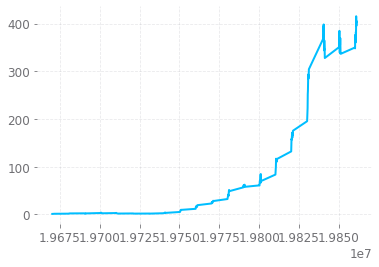

In [198]:
(np.cumprod(1+(weights[0].unstack().T * yTrain.unstack().T).sum(1))).plot()

In [155]:
Factors

,19670131,19670228,19670331,19670428,19670531,19670630,19670731,19670831,19670929,19671031,...,19860331,19860430,19860530,19860630,19860731,19860829,19860930,19861031,19861128,19861231
0,0.181980,0.080079,0.002408,-0.025128,0.067273,0.020036,0.095839,0.068385,0.075356,0.034889,...,0.075878,0.005562,-0.048435,0.028522,0.026258,-0.007665,0.100878,-0.048424,0.023973,0.038066
1,0.072409,0.084537,0.086150,-0.000820,0.065825,0.117468,0.070885,-0.010053,0.053393,0.103194,...,-0.051295,0.044307,0.084852,0.061990,-0.001940,-0.025240,-0.085946,0.072887,-0.034578,-0.030510
2,-0.003339,0.043339,0.015571,0.032021,0.013672,0.010054,-0.007815,0.016260,0.036350,0.020671,...,0.114587,0.065382,-0.033854,0.039059,0.003158,-0.118943,-0.071797,0.054971,0.066521,0.001482
3,-0.009728,0.005387,0.034772,-0.005644,0.004792,-0.048681,-0.021600,0.020893,-0.026611,-0.019353,...,0.026096,0.009426,0.034683,-0.010106,0.020847,0.103071,0.054103,0.064487,0.042428,0.056380
4,-0.100141,0.007225,-0.008245,0.012450,0.020112,0.039188,-0.020334,0.016673,0.018000,0.063412,...,0.033524,0.020625,0.014669,0.082197,0.090673,-0.065671,0.015785,-0.007992,-0.005288,0.000844


In [111]:
xTrain

A2ME        AC        AT       ATO      BEME      Beta  \
0    19670131  0.108392  0.243590  0.152681 -0.182984  0.113054  0.185315   
     19670228  0.108392  0.241259  0.150350 -0.187646  0.117716  0.178322   
     19670331  0.109302  0.241860  0.148837 -0.188372  0.118605  0.167442   
     19670428  0.109195  0.242529  0.150575 -0.182759  0.116092  0.145977   
     19670531  0.110599  0.241935  0.154378 -0.184332  0.115207  0.154378   
...                 ...       ...       ...       ...       ...       ...   
3685 19860829  0.048148 -0.060648 -0.053241 -0.105556 -0.153241 -0.010648   
     19860930  0.050973 -0.060241 -0.053753 -0.106580 -0.150602 -0.002317   
     19861031  0.052974 -0.061338 -0.051580 -0.106413 -0.149628 -0.103160   
     19861128  0.057056 -0.060317 -0.051933 -0.105030 -0.145552 -0.105496   
     19861231  0.061676 -0.061205 -0.050377 -0.104520 -0.142185 -0.139360   

                      C        CF      CF2P       CTO  ...  Resid_Var  \
0    19670131  0.113054 -0.271562  0.404429 -0.252914  ...  -0.224942   
     19670228  0.113054 -0.271562  0.406760 -0.255245  ...  -0.264569   
     19670331  0.111628 -0.272093  0.406977 -0.255814  ...  -0.248837   
     19670428  0.113793 -0.272414  0.403448 -0.251724  ...   0.067816   
     19670531  0.110599 -0.274194  0.405530 -0.253456  ...   0.101382   
...                 ...       ...       ...       ...  ...        ...   
3685 19860829 -0.203241 -0.193519 -0.252315 -0.020370  ...   0.048148   
     19860930 -0.203429 -0.193698 -0.253475 -0.022706  ...   0.071362   
     19861031 -0.204461 -0.190985 -0.253717 -0.022305  ...   0.168680   
     19861128 -0.207033 -0.191663 -0.252678 -0.020727  ...   0.143223   
     19861231 -0.209981 -0.193974 -0.252825 -0.021186  ...  -0.014124   

                    RNA       ROA       ROE       S2P     SGA2S    Spread  \
0    19670131  0.045455  0.059441  0.080420 -0.015152 -0.383450 -0.164336   
     19670228  0.040793  0.057110  0.078089 -0.015152 -0.383450  0.175991   
     19670331  0.039535  0.055814  0.076744 -0.013953 -0.383721  0.172093   
     19670428  0.042529  0.056322  0.077011 -0.012644 -0.385057  0.070115   
     19670531  0.039171  0.052995  0.073733 -0.011521 -0.382488 -0.211982   
...                 ...       ...       ...       ...       ...       ...   
3685 19860829 -0.245833 -0.250463 -0.250926  0.098611  0.406481 -0.017593   
     19860930 -0.248842 -0.252549 -0.253012  0.099629  0.408248  0.217794   
     19861031 -0.247677 -0.253253 -0.254182  0.102230  0.407063  0.077138   
     19861128 -0.246623 -0.254075 -0.255007  0.106428  0.406381  0.134839   
     19861231 -0.249058 -0.258004 -0.258004  0.110169  0.407250 -0.196798   

                 ST_REV       SUV  Variance  
0    19670131 -0.241259 -0.325175 -0.182984  
     19670228  0.071096 -0.374126 -0.217949  
     19670331 -0.269767  0.179070  0.025581  
     19670428  0.389655  0.428736  0.226437  
     19670531  0.101382 -0.029954  0.080645  
...                 ...       ...       ...  
3685 19860829  0.352315 -0.299074  0.100000  
     19860930 -0.151993  0.465709  0.144115  
     19861031  0.460502  0.280669  0.187732  
     19861128  0.334653  0.087797  0.153004  
     19861231 -0.174670 -0.221281 -0.000942  

[884640 rows x 46 columns]

In [104]:
weights[0]

,,A2ME,AC,AT,ATO,BEME,Beta,C,CF,CF2P,CTO,...,Resid_Var,RNA,ROA,ROE,S2P,SGA2S,Spread,ST_REV,SUV,Variance
0,19671031,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,19671031,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,19671031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,19671031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,19671031,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3681,19671031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3682,19671031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3683,19671031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3684,19671031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [85]:
part = xTrain[xTrain.index.get_level_values(1) < dates[0]]
Zt = part[part.index.get_level_values(1) == part.index.get_level_values(1)[-1]]
notna_t = ~pd.isna(Zt)
Zt.dropna()

,,A2ME,AC,AT,ATO,BEME,Beta,C,CF,CF2P,CTO,...,Resid_Var,RNA,ROA,ROE,S2P,SGA2S,Spread,ST_REV,SUV,Variance
0,19671031,0.089909,-0.179172,0.269728,-0.219276,0.119664,0.126132,0.265847,-0.326649,0.406856,-0.302070,...,-0.212807,0.054981,0.098965,0.110608,-0.074386,-0.327943,-0.130013,-0.265847,0.007115,-0.247736
1,19671031,0.272316,0.062743,-0.282665,0.382277,0.333118,0.175291,0.311125,-0.280078,0.158473,0.194696,...,0.360285,0.264554,-0.374515,-0.371928,0.375809,-0.290427,0.418499,0.193402,-0.483182,0.351229
4,19671031,-0.040750,0.084735,0.313713,-0.260673,0.018758,0.153299,-0.238680,-0.058862,0.336999,-0.312419,...,-0.282665,-0.117076,-0.104140,-0.141656,-0.171410,-0.034282,0.076973,-0.375809,0.302070,-0.303364
5,19671031,0.091203,-0.022639,0.453428,-0.258085,0.097671,0.003234,-0.348642,-0.357697,0.374515,-0.334411,...,-0.274903,-0.123545,-0.088616,-0.133894,-0.132600,-0.186934,0.086028,0.016171,0.278784,-0.265847
7,19671031,0.402975,-0.401682,0.368047,-0.141656,0.412031,0.479301,-0.206339,-0.093790,0.267141,-0.122251,...,0.481889,-0.217982,-0.317594,-0.311125,0.331824,-0.149418,0.427555,0.054981,0.164942,0.484476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1508,19671031,-0.448254,0.325356,-0.252911,-0.004528,-0.395213,0.014877,0.251617,0.436611,-0.353816,0.082147,...,-0.092497,0.294308,0.488357,0.436611,-0.414618,0.053687,0.044631,-0.434023,-0.339586,-0.061449
1510,19671031,0.444373,0.467658,0.018758,-0.267141,0.390039,-0.047219,0.109314,0.304657,0.449547,-0.309832,...,0.057568,-0.258085,-0.338292,-0.163648,0.335705,0.265847,0.137775,-0.458603,-0.018758,0.018758
2847,19671031,-0.212807,-0.461190,-0.412031,-0.404269,-0.066624,0.391332,-0.108021,-0.397801,-0.488357,-0.276197,...,0.186934,0.383571,-0.494825,-0.488357,-0.291721,0.434023,0.365459,-0.136481,-0.194696,0.150712
2897,19671031,0.013583,0.265847,0.097671,0.471539,0.167529,0.355110,-0.061449,0.195990,0.246442,-0.100259,...,0.223157,0.481889,0.153299,0.048512,0.044631,0.136481,0.225744,0.098965,0.154592,0.249030


In [95]:
coefs.shape

(5, 774)

In [97]:
Zt[notna_t] = coefs.T

In [75]:
len(gammas)

230

In [78]:
dates

Int64Index([19671130, 19671229, 19680131, 19680229, 19680329, 19680430,
            19680531, 19680628, 19680730, 19680830,
            ...
            19860331, 19860430, 19860530, 19860630, 19860731, 19860829,
            19860930, 19861031, 19861128, 19861231],
           dtype='int64', length=230)

In [71]:
dates

Int64Index([19670131, 19670228, 19670331, 19670428, 19670531, 19670630,
            19670731, 19670831, 19670929, 19671031,
            ...
            19860331, 19860430, 19860530, 19860630, 19860731, 19860829,
            19860930, 19861031, 19861128, 19861231],
           dtype='int64', length=884640)

In [21]:
xTrain.index.get_level_values(1).unique()

Int64Index([19670131, 19670228, 19670331, 19670428, 19670531, 19670630,
            19670731, 19670831, 19670929, 19671031,
            ...
            19860331, 19860430, 19860530, 19860630, 19860731, 19860829,
            19860930, 19861031, 19861128, 19861231],
           dtype='int64', length=240)

In [66]:
#gamma, factors, dates = rollingIPCA(xTrain, yTrain, k=5, burnin=100)

In [395]:
Z = xVal.groupby(xVal.index.get_level_values(0)).last()

In [396]:
yTrain

0     19670131    0.136223
      19670228   -0.039703
      19670331    0.152727
      19670428    0.048883
      19670531   -0.022112
                    ...   
3685  19860829   -0.010414
      19860930    0.147547
      19861031    0.127380
      19861128   -0.030806
      19861231    0.013533
Name: ret, Length: 884640, dtype: float64

In [397]:
yVal.groupby(yVal.index.get_level_values(0)).last()

0       0.149261
1      -0.112891
2       0.196200
3       0.213591
4       0.183700
          ...   
3342    0.061873
3343    0.007121
3344   -0.070134
3345    0.020590
3346   -0.106364
Name: ret, Length: 3347, dtype: float64

In [400]:
yTrain.reset_index().pivot(index = 'level_1', columns = 'level_0', values = 'ret')

level_0,0,1,2,3,4,5,6,7,8,9,...,3676,3677,3678,3679,3680,3681,3682,3683,3684,3685
level_1,,,,,,,,,,,,,,,,,,,,,
19670131,0.136223,0.317129,NaN,NaN,0.101064,0.287367,NaN,0.143427,NaN,0.162367,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19670228,-0.039703,-0.003600,NaN,NaN,0.025863,-0.038263,NaN,-0.013501,NaN,-0.066758,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19670331,0.152727,-0.057954,NaN,NaN,0.108345,0.005504,NaN,0.036504,NaN,0.012316,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19670428,0.048883,0.053943,NaN,NaN,0.036555,0.043384,NaN,-0.071161,NaN,0.076587,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19670531,-0.022112,-0.003300,NaN,NaN,-0.068006,-0.089947,NaN,-0.029342,NaN,0.030690,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19860829,NaN,NaN,0.110785,NaN,NaN,0.003158,-0.045416,-0.076029,0.063582,0.317239,...,0.024054,-0.015353,0.007340,0.002543,0.106511,0.062067,0.035400,0.038878,-0.004600,-0.010414
19860930,NaN,NaN,-0.096454,NaN,NaN,-0.016658,-0.025777,-0.158346,-0.089606,-0.047978,...,0.033059,-0.017978,0.189530,-0.041537,-0.191167,-0.046167,-0.004500,1.495500,-0.104500,0.147547
19861031,NaN,NaN,0.081476,NaN,NaN,0.001554,-0.106339,0.177218,0.007028,-0.059145,...,-0.022700,0.195400,-0.092100,-0.004600,-0.037387,-0.156774,-0.119985,NaN,0.162067,0.127380


In [402]:
zgam = Z @ Gamma
rets_t = np.linalg.inv(zgam.T @ zgam) @ zgam.T @ yVal.groupby(yVal.index.get_level_values(0)).last().values
rets_t

0   -0.101972
1    0.064366
2    0.104899
3    0.057718
4    0.009644
dtype: float64

In [403]:
regr.predictOOS(xVal, yVal, mean_factor=False)#.reshape(valSet.shape[0], valSet.shape[1]).shape

array([0.00470905])

In [309]:
Factors.iloc[0,:]

19670131    0.455041
19670228    0.431166
19670331    0.395302
19670428    0.393316
19670531    0.430149
              ...   
19860829    0.395480
19860930    0.459892
19861031    0.355849
19861128    0.391045
19861231    0.415202
Name: 0, Length: 240, dtype: float64

In [1]:
plt.plot(Factors.T.values)

NameError: name 'plt' is not defined

In [308]:
Gamma

,0,1,2,3,4
A2ME,0.485289,-0.105882,-0.257739,-0.218769,0.055338
AC,0.035715,-0.050916,-0.015234,-0.058490,0.037240
AT,-0.072397,-0.347041,0.076957,-0.038999,0.032718
ATO,0.082339,0.001534,0.012201,-0.097195,-0.086933
BEME,0.261850,0.086397,-0.084106,0.113983,-0.116108
Beta,0.006342,0.003798,-0.027872,-0.023069,0.554245
C,0.112988,0.030565,-0.025348,0.030786,-0.015661
CF,0.083393,-0.000507,-0.019978,0.007821,-0.017924
CF2P,-0.036978,0.077533,0.012938,0.075145,-0.009196
CTO,-0.309002,0.086495,-0.169719,0.156650,-0.053901


In [8]:
import numpy as np
from statsmodels.datasets import grunfeld
data = grunfeld.load_pandas().data
data.year = data.year.astype(np.int64)

# Establish unique IDs to conform with package
N = len(np.unique(data.firm))
ID = dict(zip(np.unique(data.firm).tolist(),np.arange(1,N+1)))
data.firm = data.firm.apply(lambda x: ID[x])

# use multi-index for panel groups
data = data.set_index(['firm', 'year'])
y = data['invest']
X = data.drop('invest', axis=1)

# Call ipca
from ipca import InstrumentedPCA
regr = InstrumentedPCA(n_factors=1, intercept=False)
regr = regr.fit(X=X, y=y)
Gamma, Factors = regr.get_factors(label_ind=True)

The panel dimensions are:
n_samples: 11 , L: 2 , T: 20


Step 1 - Aggregate Update: 991040.1067154527
Step 2 - Aggregate Update: 0.031168457034450703
Step 3 - Aggregate Update: 0.013774627857863875
Step 4 - Aggregate Update: 0.0060456374632660015
Step 5 - Aggregate Update: 0.0026463970950459936
Step 6 - Aggregate Update: 0.0011571703804040545
Step 7 - Aggregate Update: 0.0005057548444780402
Step 8 - Aggregate Update: 0.00022100228661872667
Step 9 - Aggregate Update: 9.656419373593739e-05
Step 10 - Aggregate Update: 4.2190938680158885e-05
Step 11 - Aggregate Update: 1.8433811879242645e-05
Step 12 - Aggregate Update: 8.053932980756073e-06
-- Convergence Reached --


In [9]:
Gamma

,0
value,0.991659
capital,0.128886


In [10]:
Factors

,1935,1936,1937,1938,1939,1940,1941,1942,1943,1944,1945,1946,1947,1948,1949,1950,1951,1952,1953,1954
0,0.103197,0.088449,0.08385,0.084507,0.072252,0.099507,0.122884,0.142262,0.119753,0.117973,0.108756,0.135752,0.157935,0.166054,0.148492,0.158663,0.159601,0.175938,0.192169,0.211106


In [16]:
X

value  capital
firm year                   
6    1935  3078.500    2.800
     1936  4661.700   52.600
     1937  5387.100  156.900
     1938  2792.200  209.200
     1939  4313.200  203.400
...             ...      ...
1    1950    36.494   75.847
     1951    46.082   77.367
     1952    57.616   78.631
     1953    57.441   80.215
     1954    47.165   83.788

[220 rows x 2 columns]

In [14]:
data

invest     value  capital
firm year                            
6    1935  317.600  3078.500    2.800
     1936  391.800  4661.700   52.600
     1937  410.600  5387.100  156.900
     1938  257.700  2792.200  209.200
     1939  330.800  4313.200  203.400
...            ...       ...      ...
1    1950    4.770    36.494   75.847
     1951    6.532    46.082   77.367
     1952    7.329    57.616   78.631
     1953    9.020    57.441   80.215
     1954    6.281    47.165   83.788

[220 rows x 3 columns]